In [1]:
!pip install qiskit qiskit-machine-learning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 9.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [3]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.optimizers import COBYLA
from matplotlib import pyplot as plt
from IPython.display import clear_output



In [4]:
# Download NLTK data
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv('/content/Restaurant_Reviews.tsv', delimiter='\t', quoting=3)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)



In [6]:
corpus = []
ps = PorterStemmer()

for i in range(0, df.shape[0]):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=df.Review[i])  # Clean special characters
    message = message.lower()  # Convert to lowercase
    words = message.split()  # Tokenize
    words = [word for word in words if word not in set(stopwords.words('english'))]  # Remove stopwords
    words = [ps.stem(word) for word in words]  # Stemming
    message = ' '.join(words)  # Join the words back
    corpus.append(message)


In [7]:

cv = CountVectorizer()  # Removed max_features to allow all words
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:, 1].values


In [19]:
from sklearn.decomposition import PCA

# Reduce dimensions to fit quantum circuits
num_qubits = 4  # Set the number of qubits based on the system's capability
pca = PCA(n_components=num_qubits)
X_reduced = pca.fit_transform(X_scaled)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=0)

In [21]:
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)

In [22]:
optimizer = COBYLA(maxiter=100)
sampler = Sampler()

<ipython-input-22-8baa1901b575>:2: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [23]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    objective_func_vals.append(obj_func_eval)
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.title("Objective Function Value vs Iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective Function Value")
    plt.pause(0.1)

In [24]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

In [17]:
objective_func_vals = []


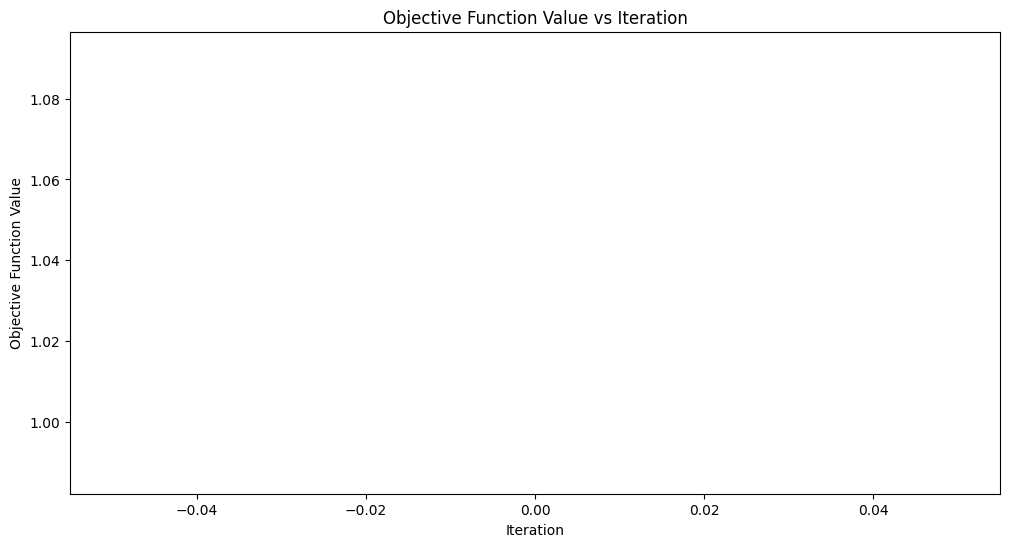

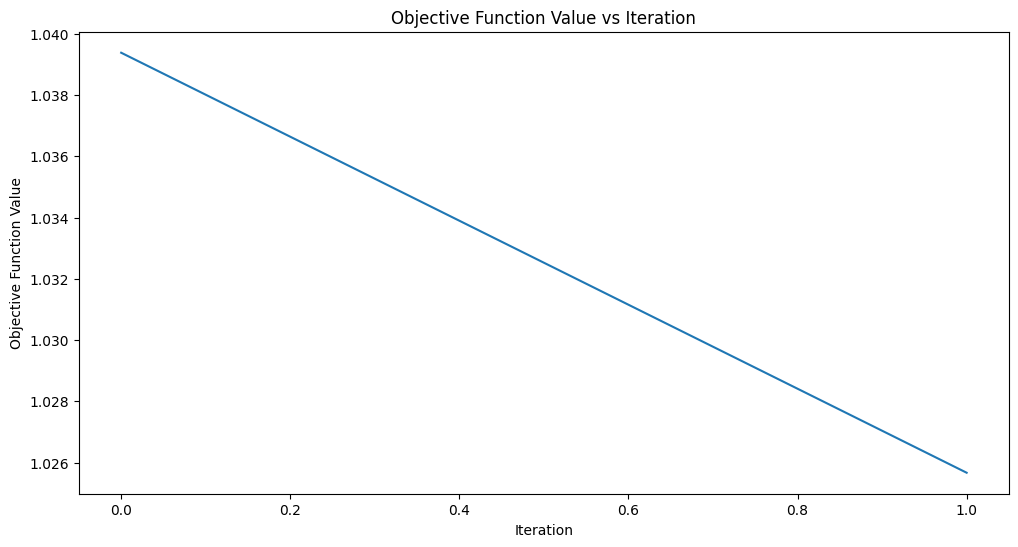

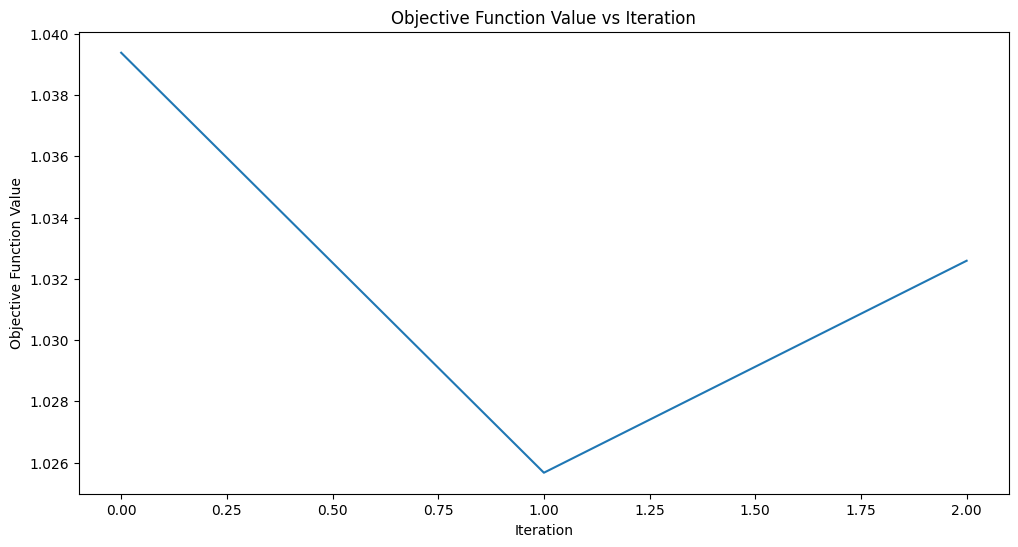

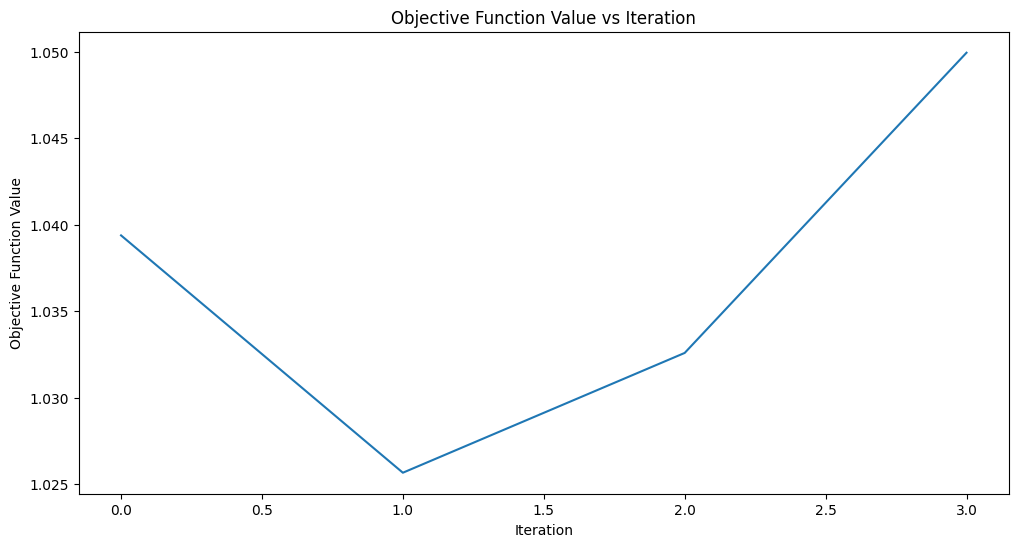

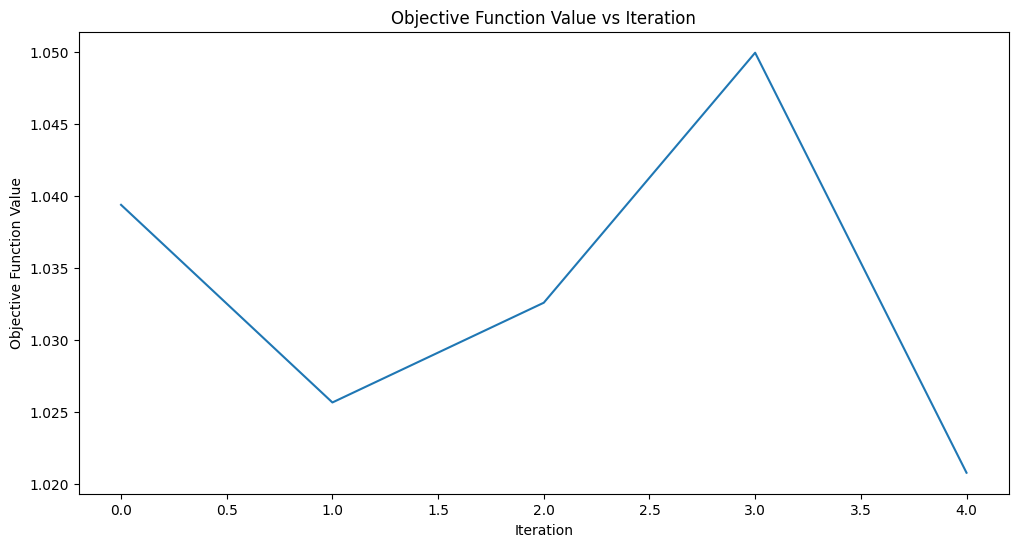

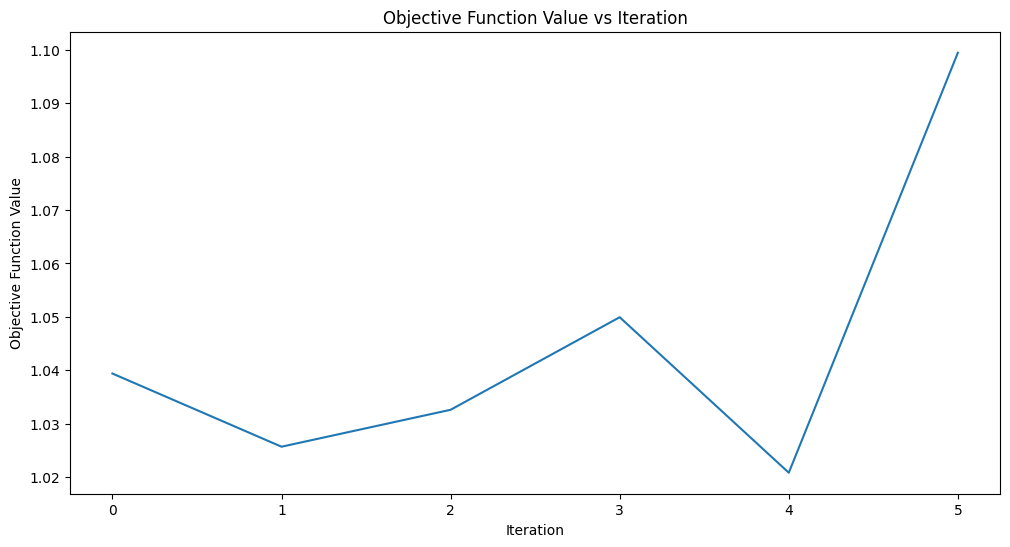

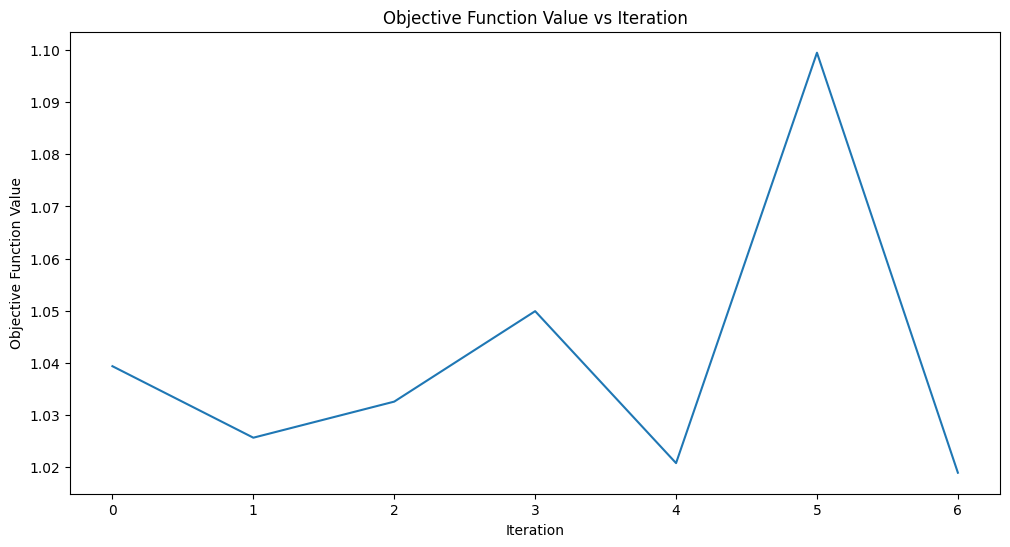

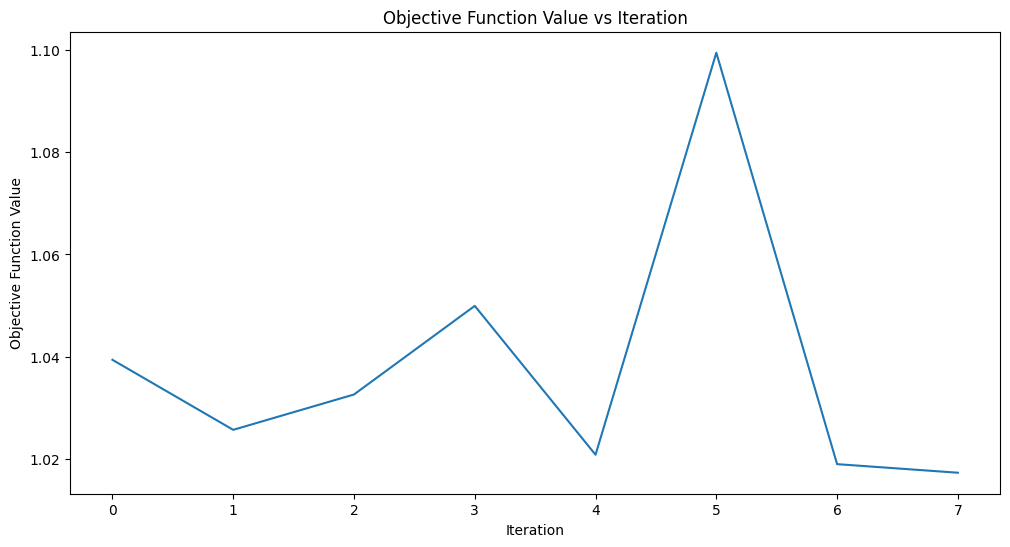

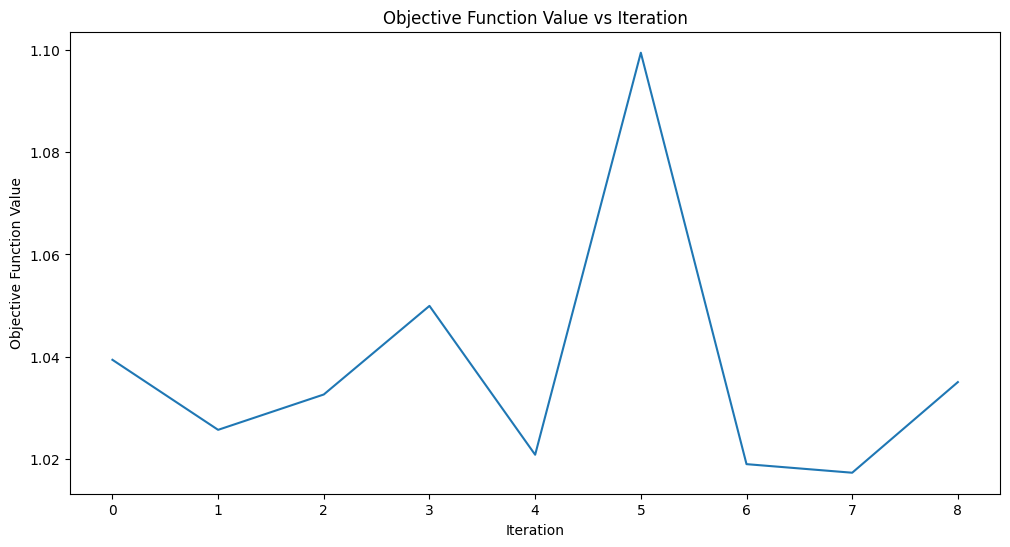

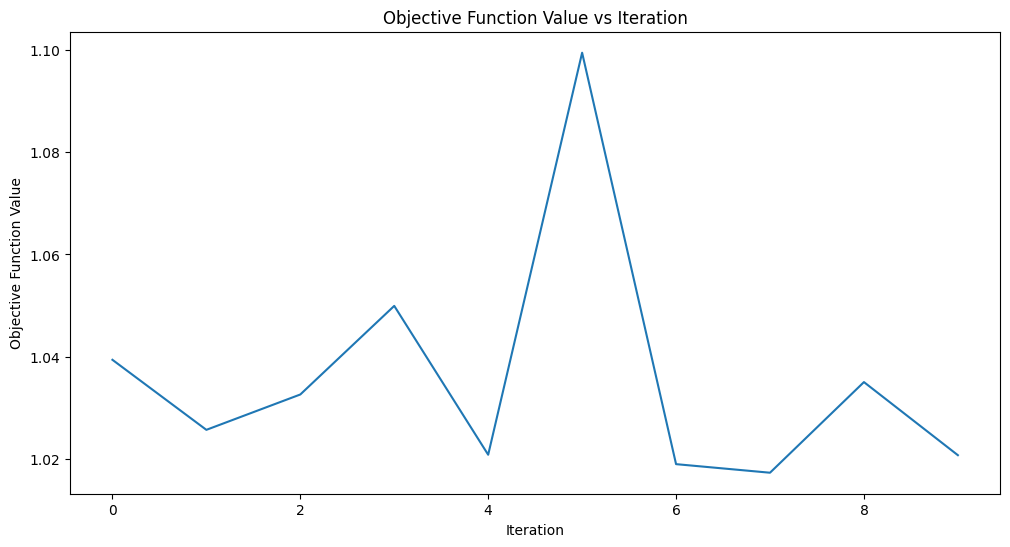

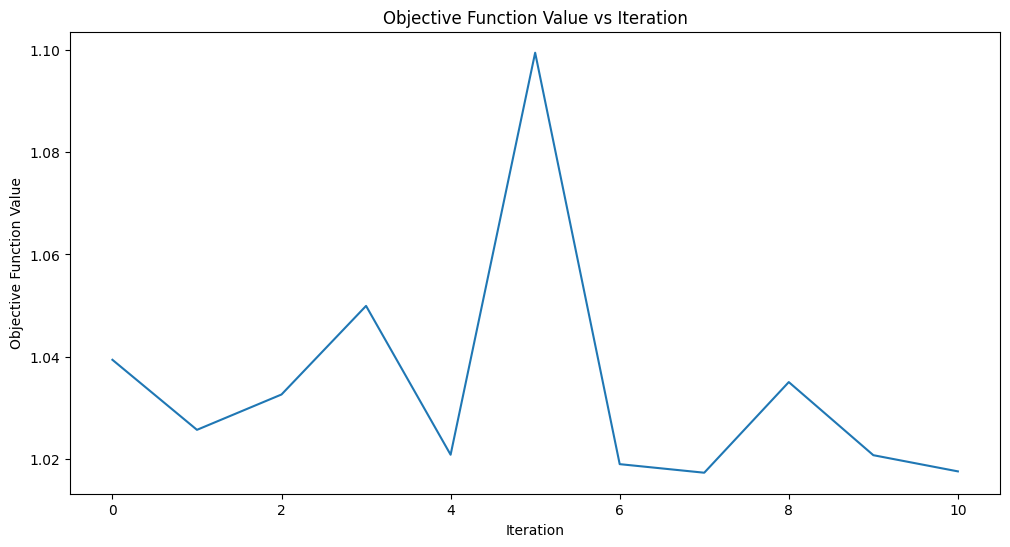

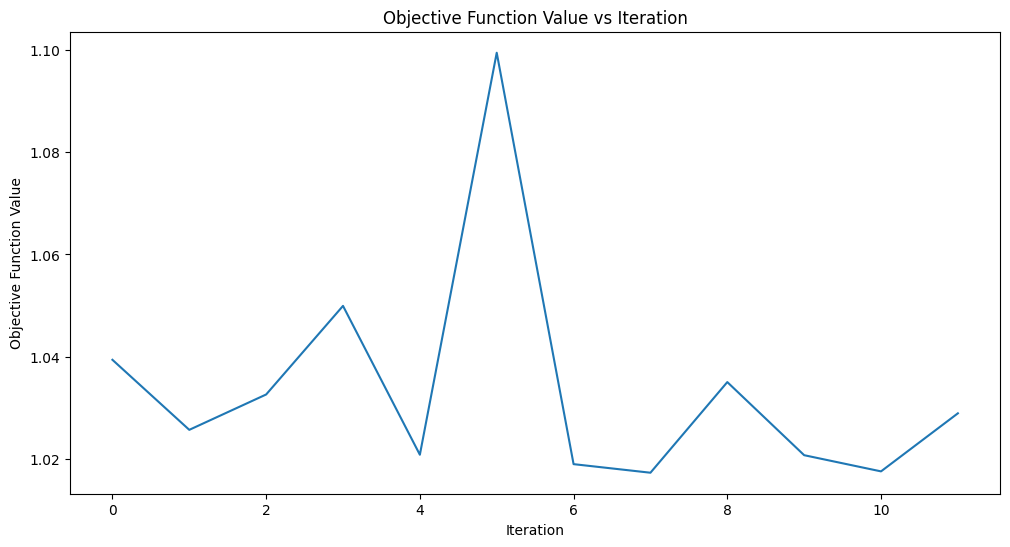

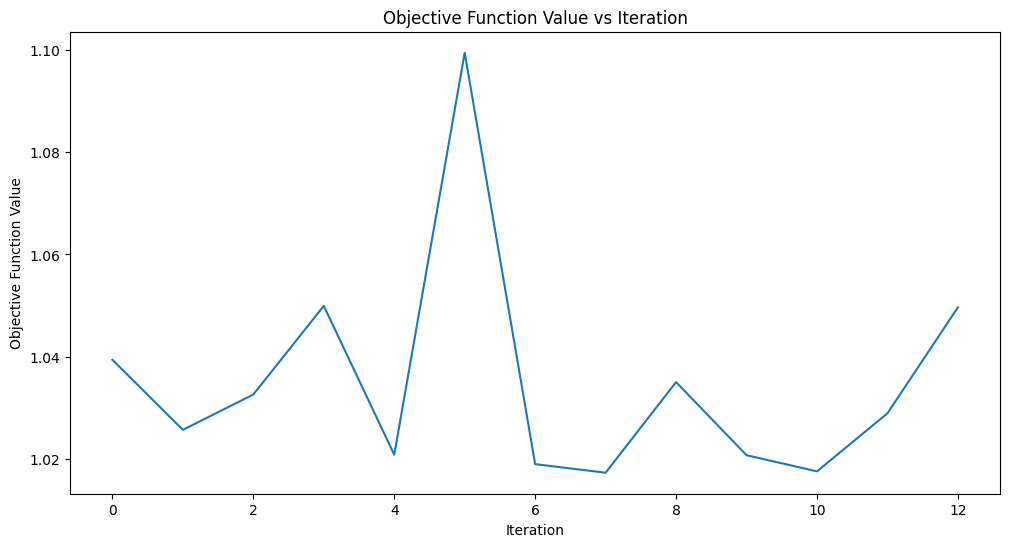

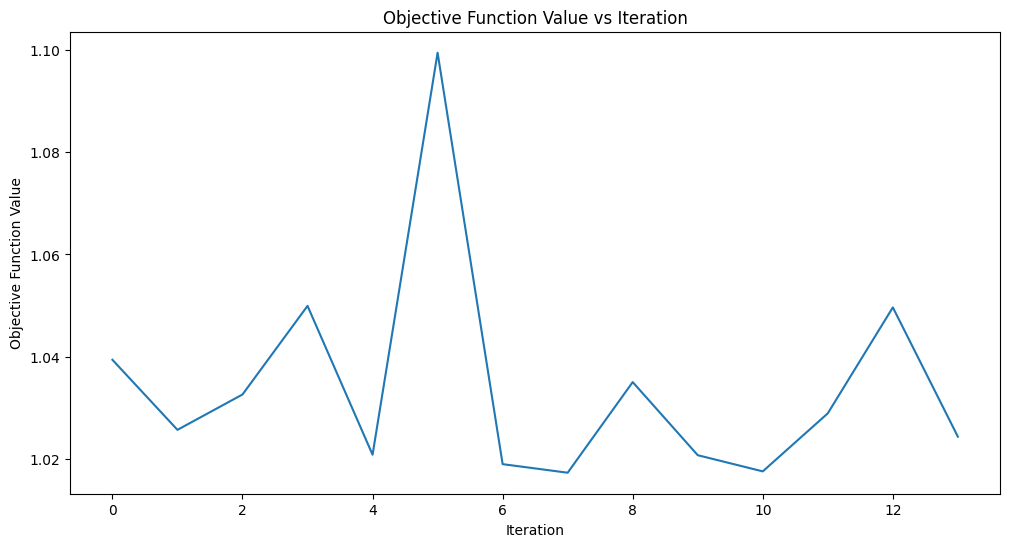

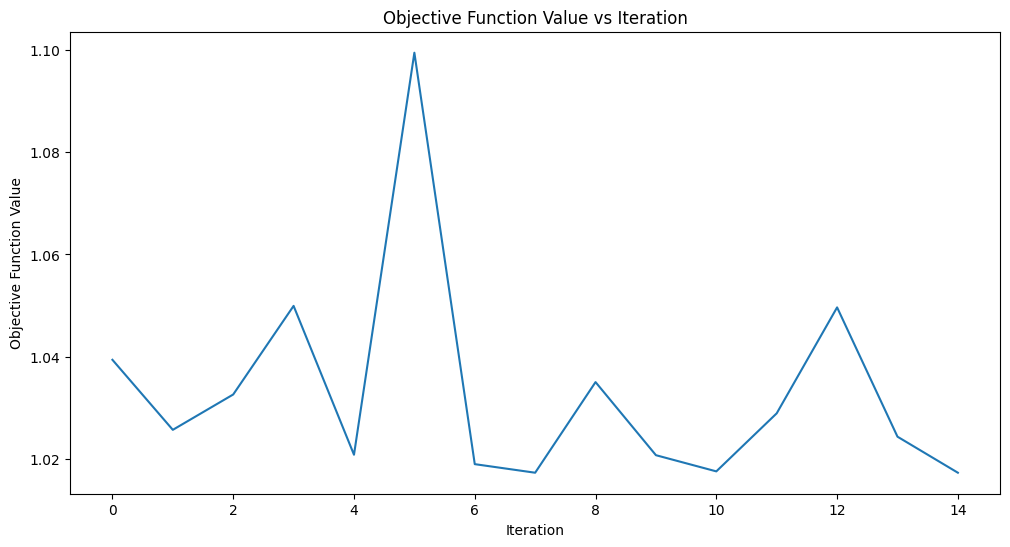

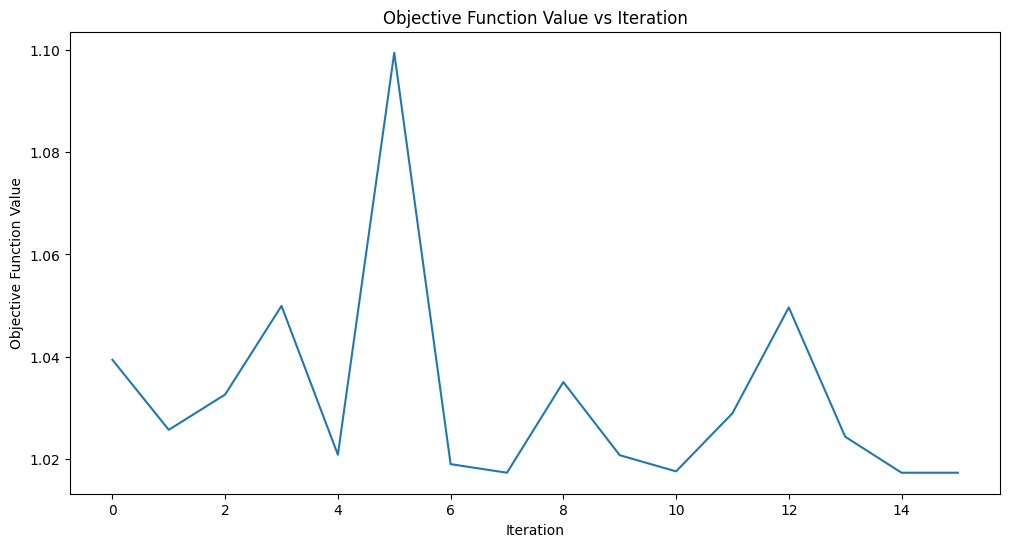

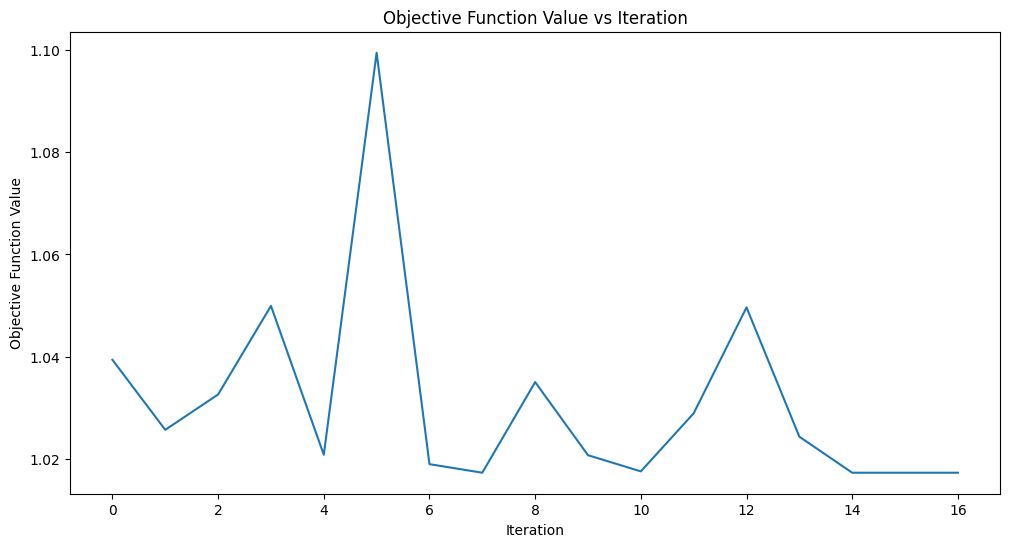

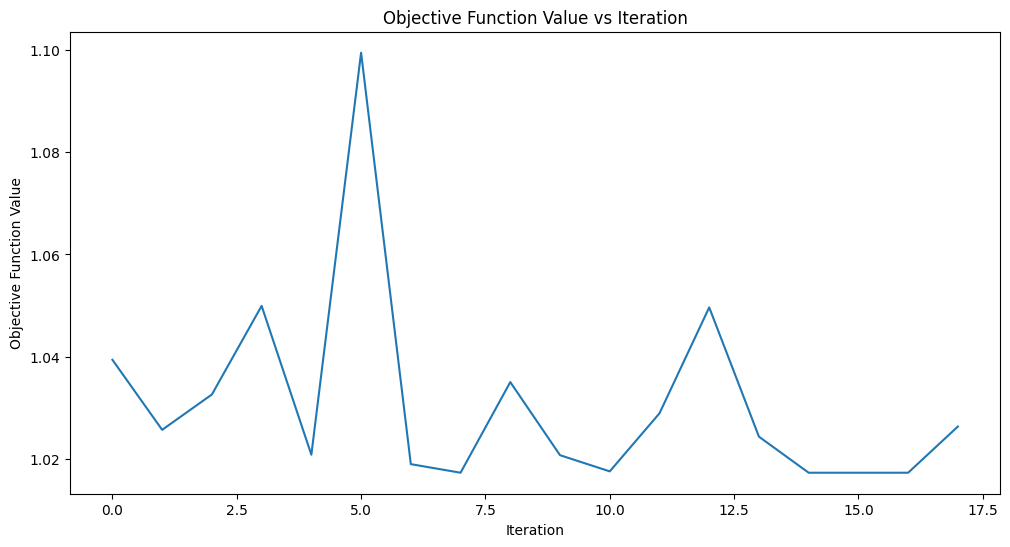

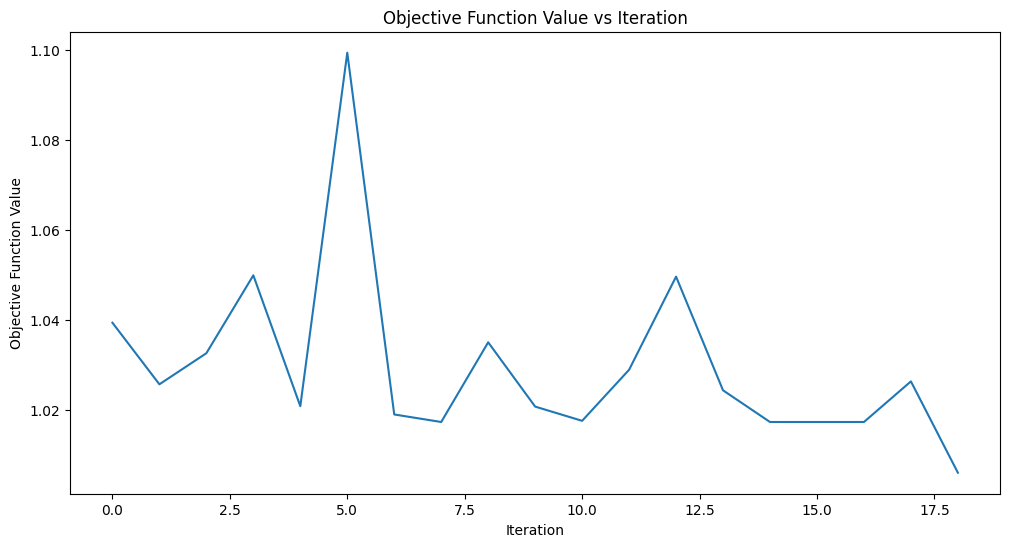

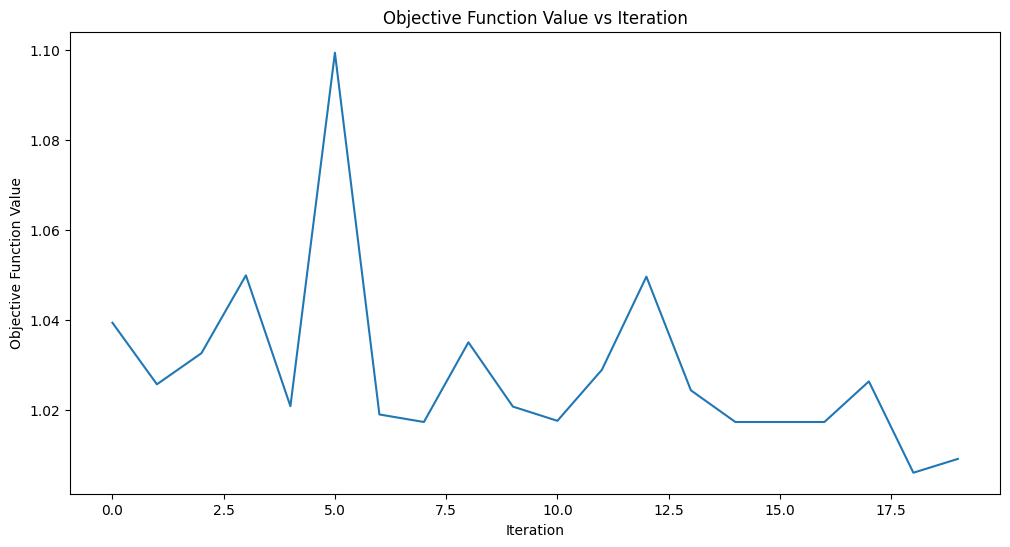

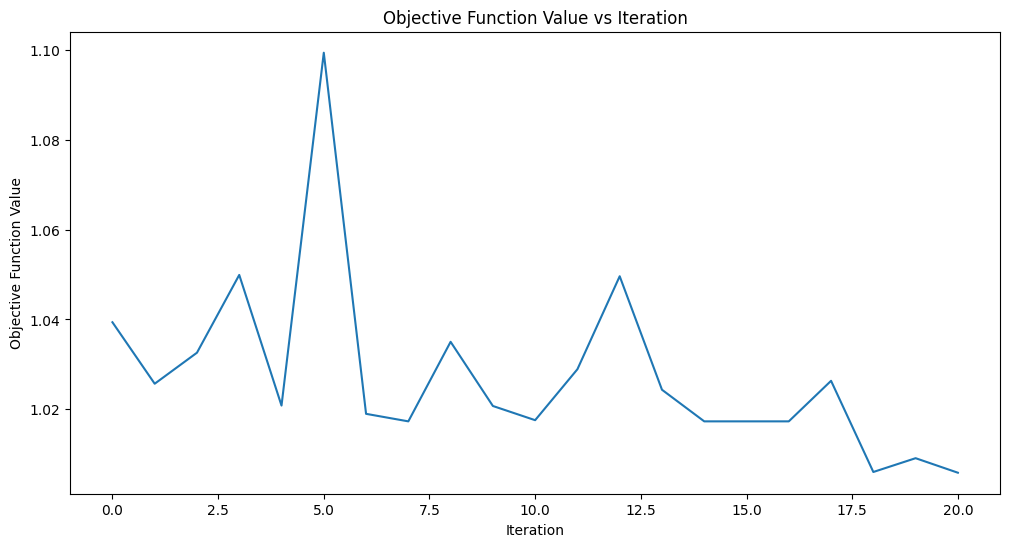

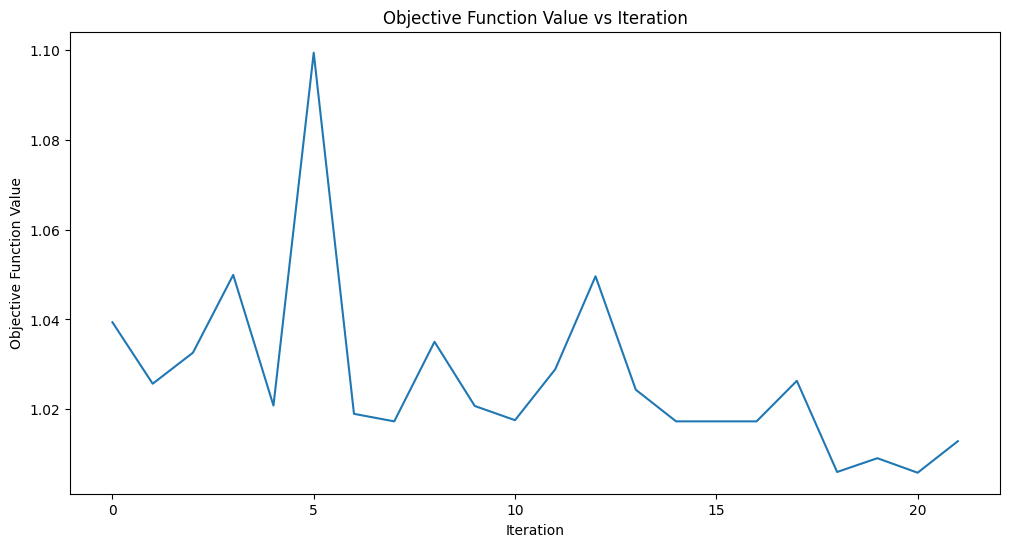

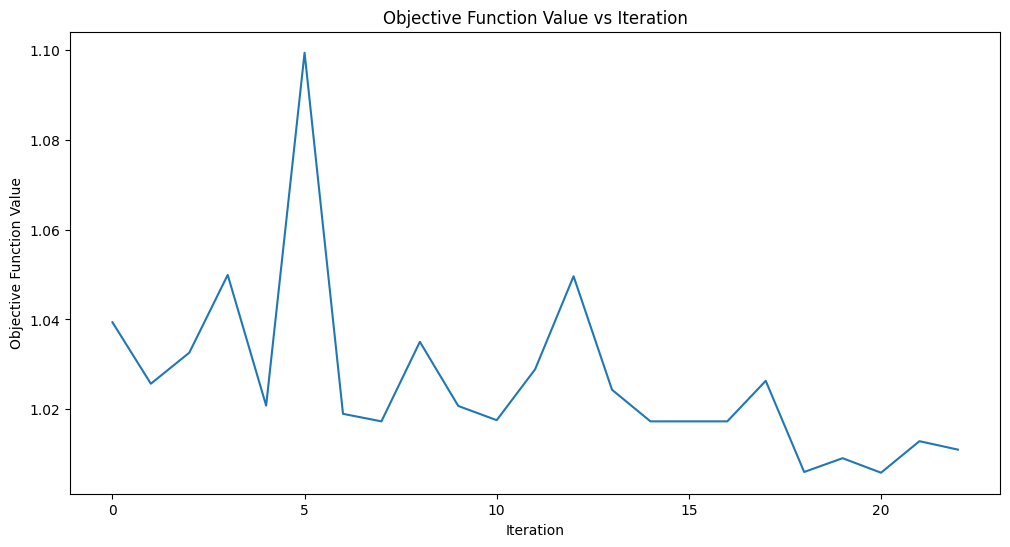

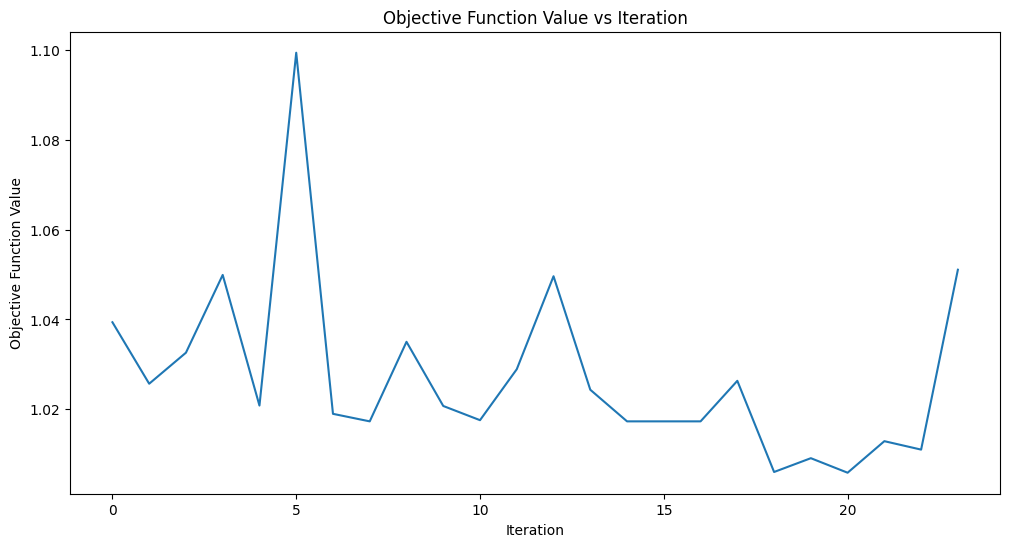

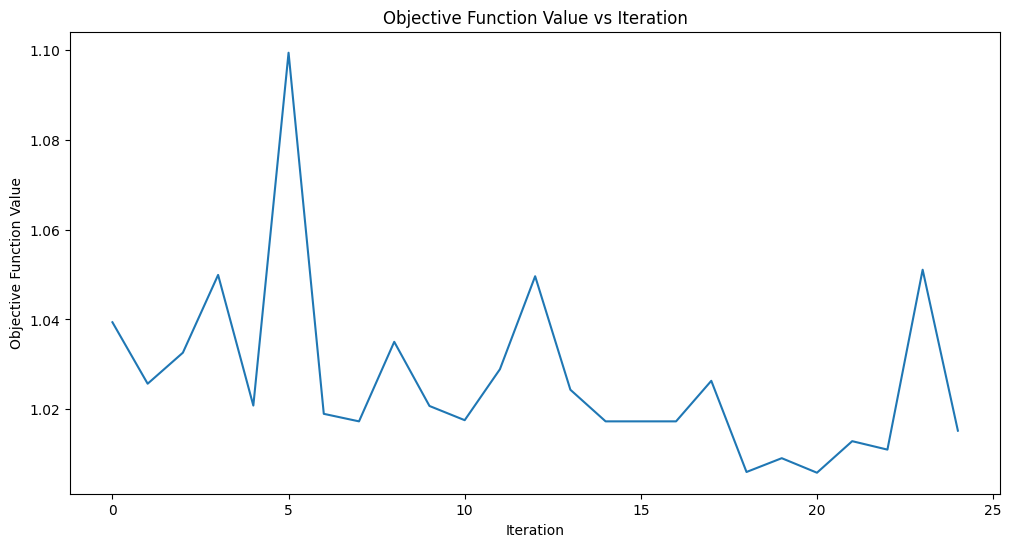

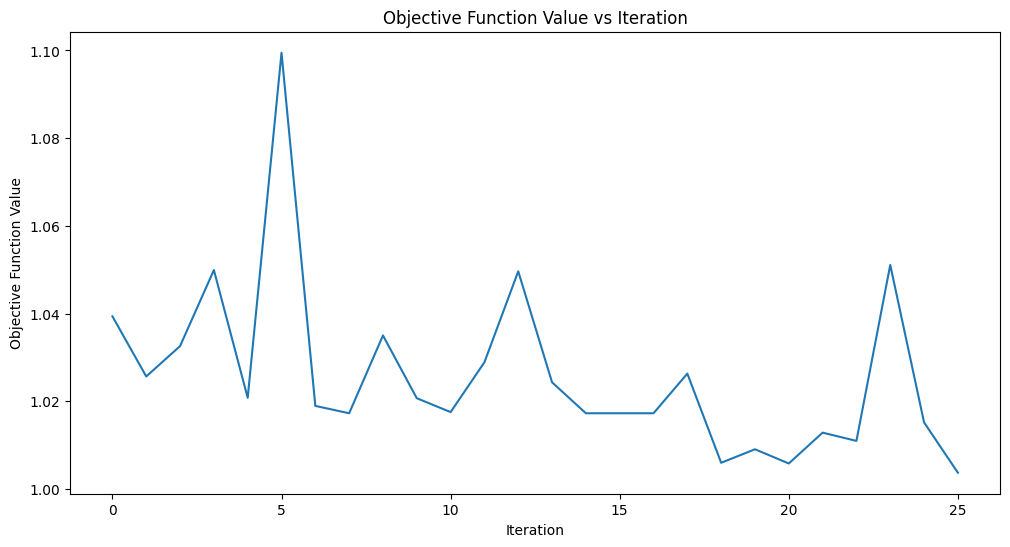

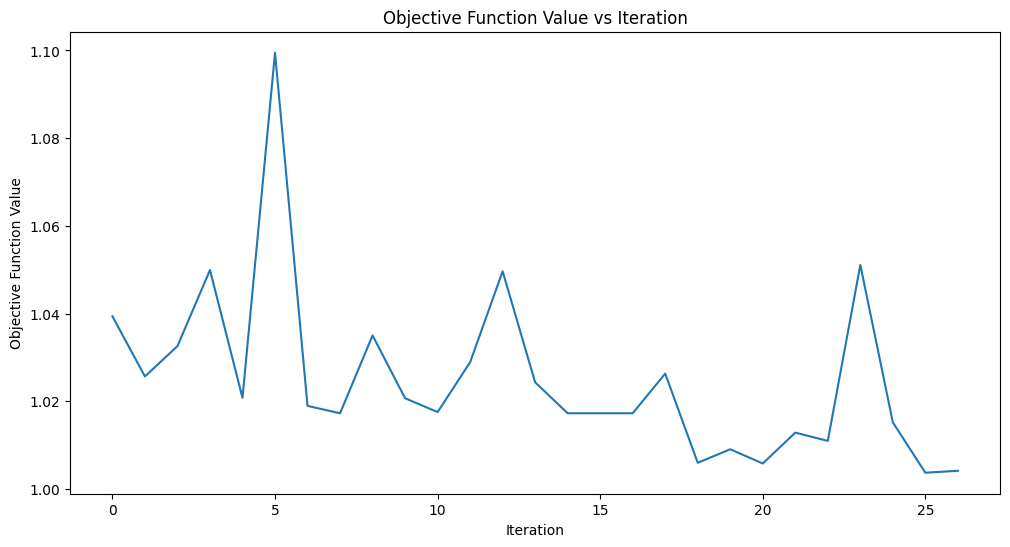

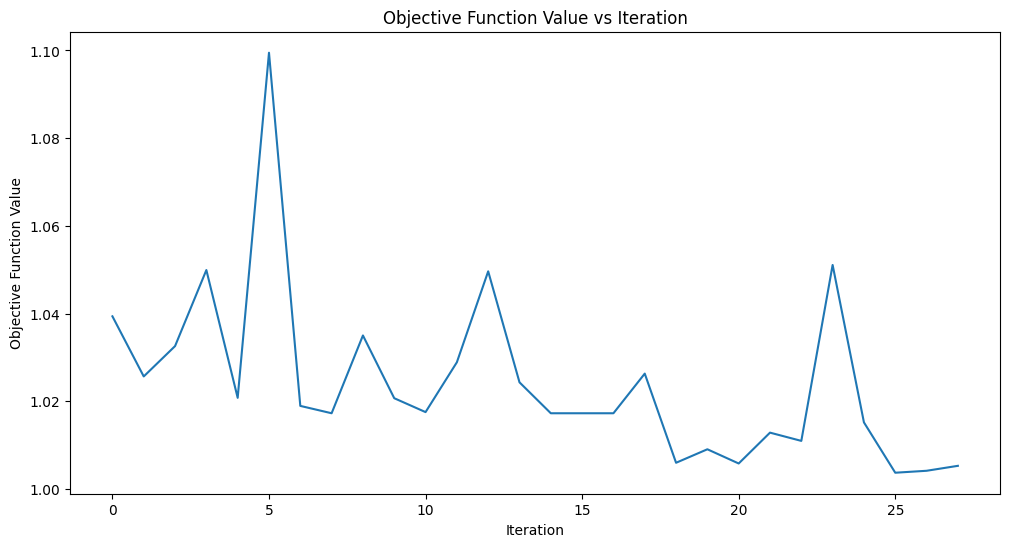

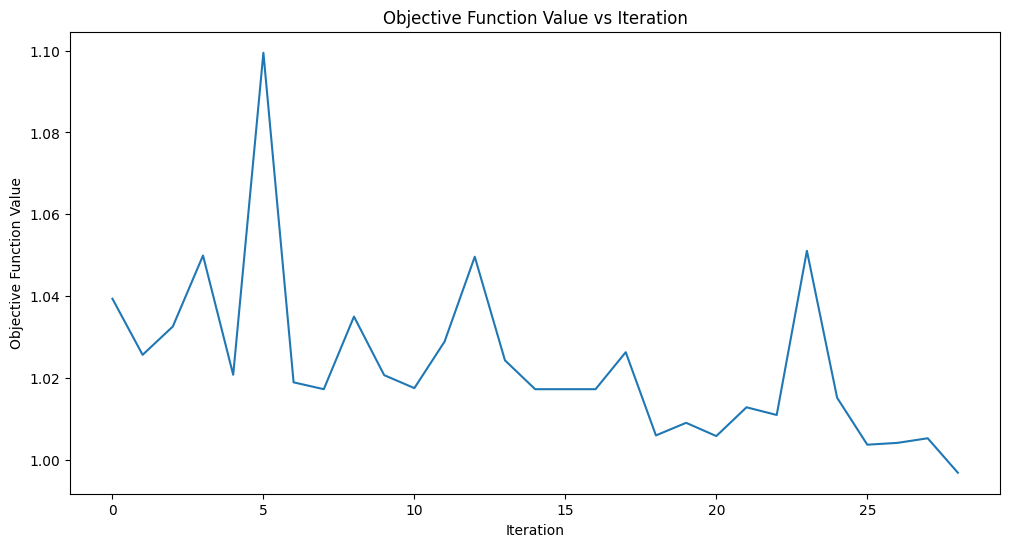

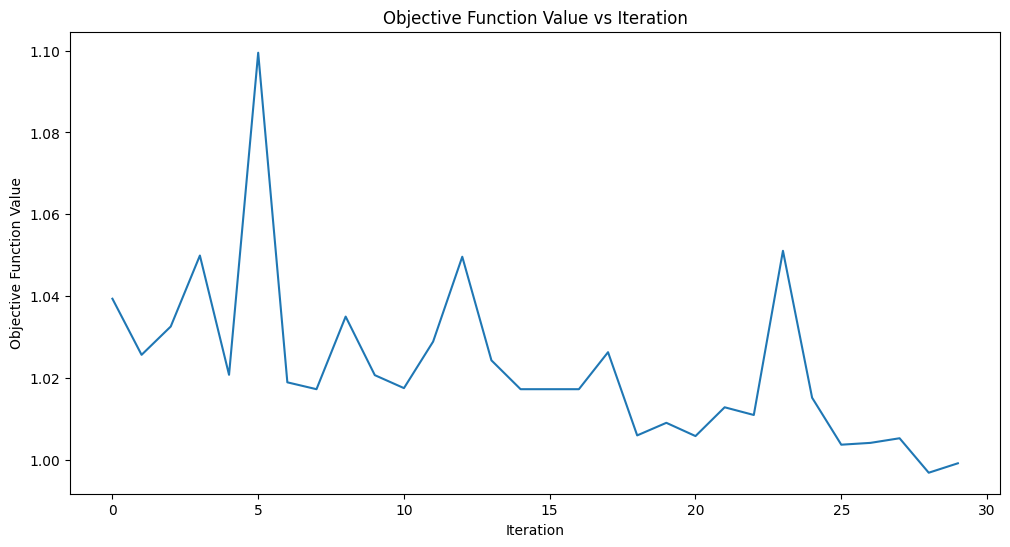

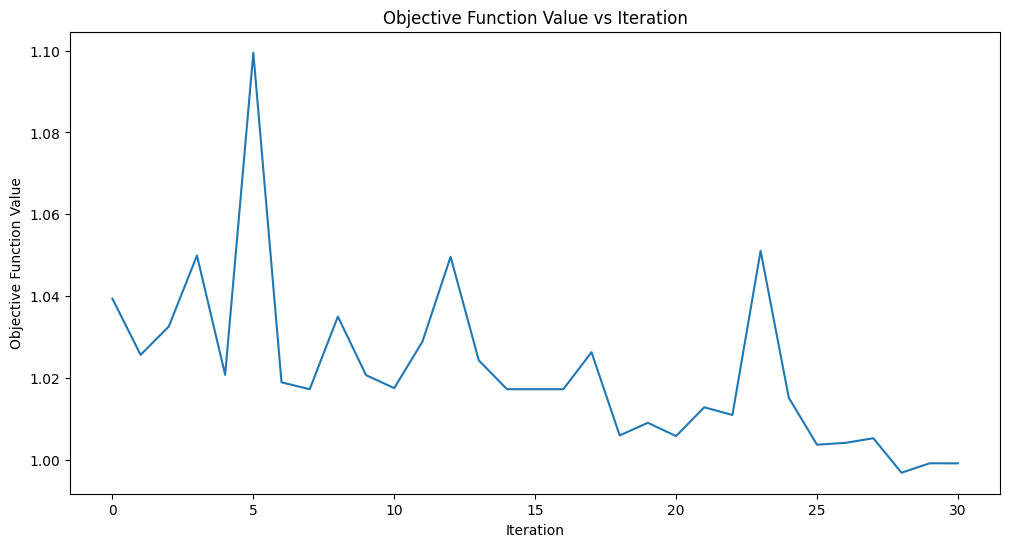

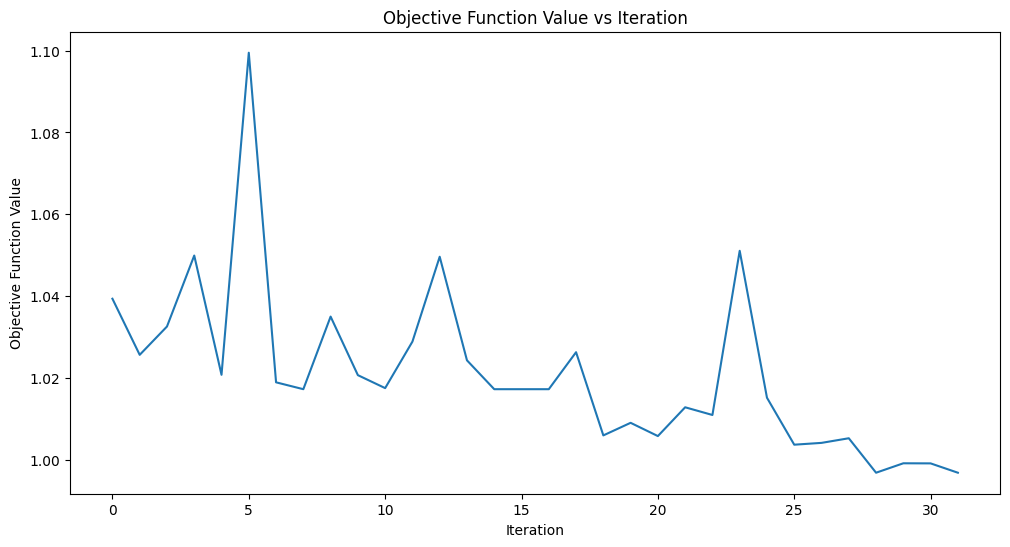

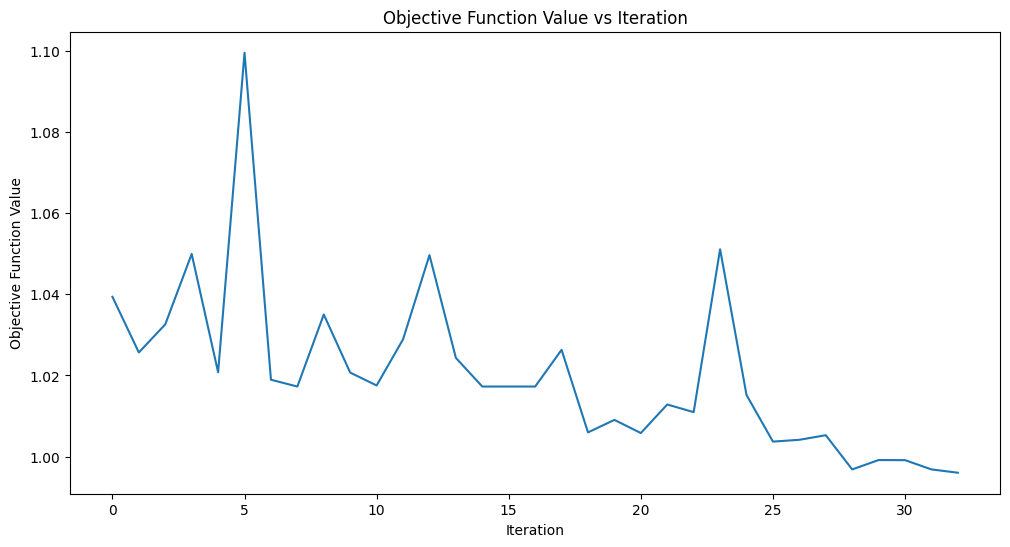

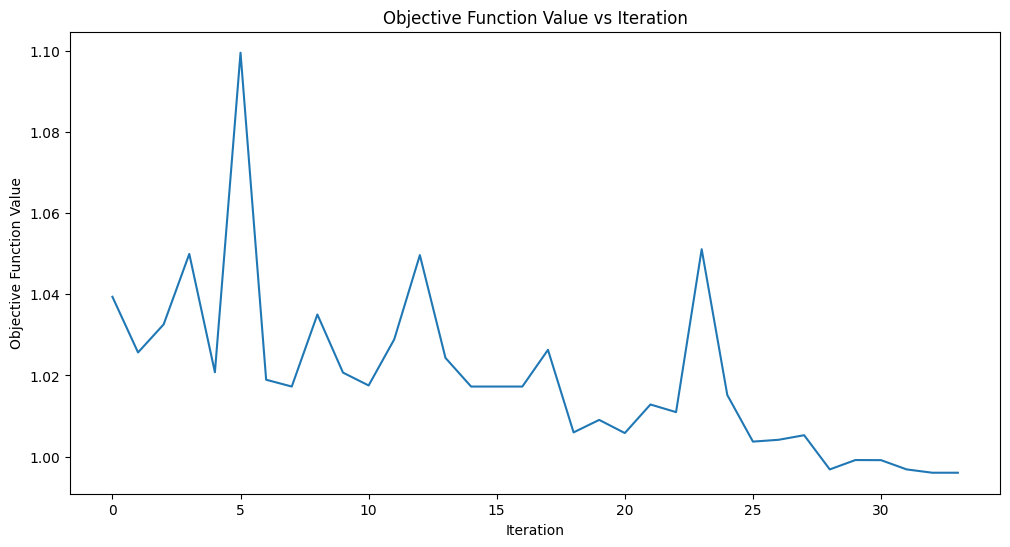

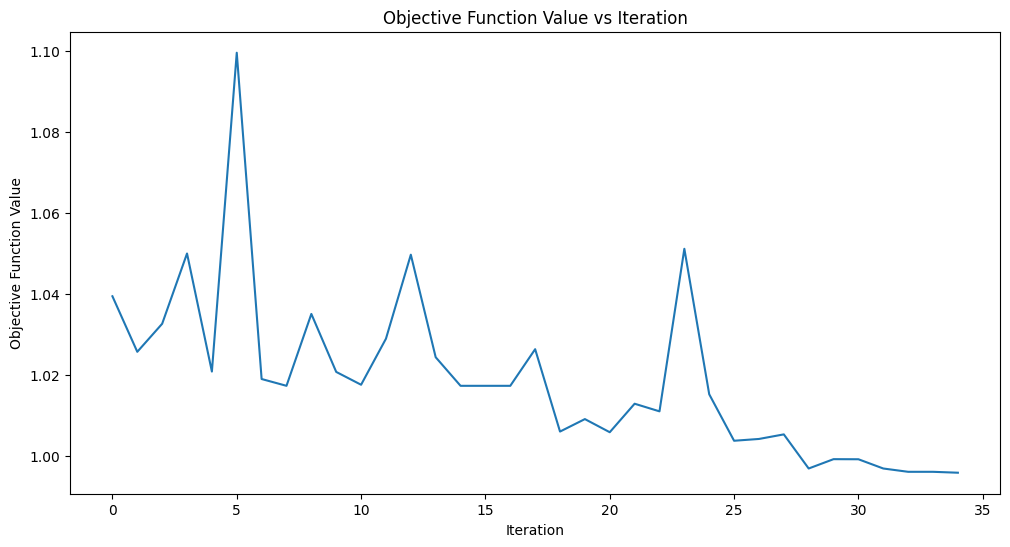

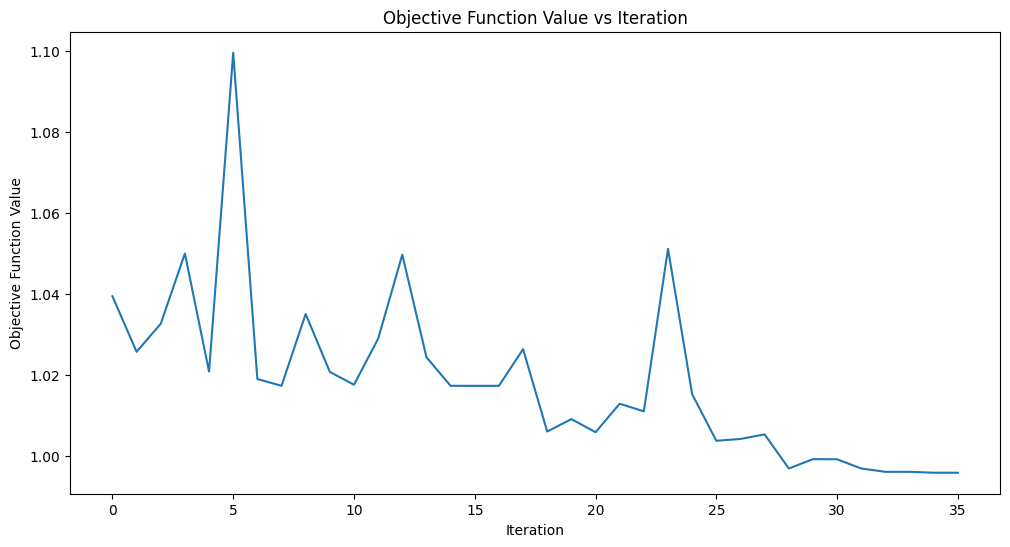

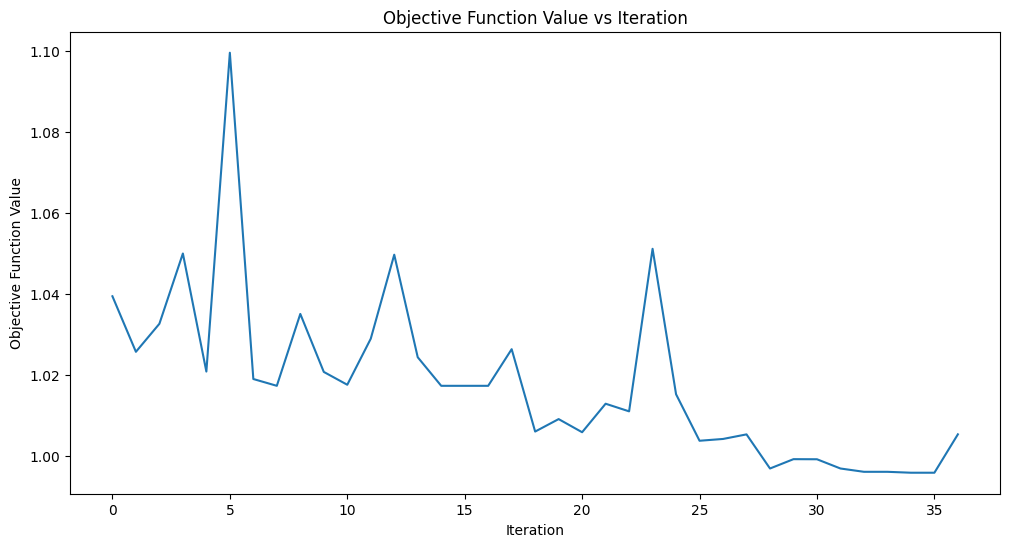

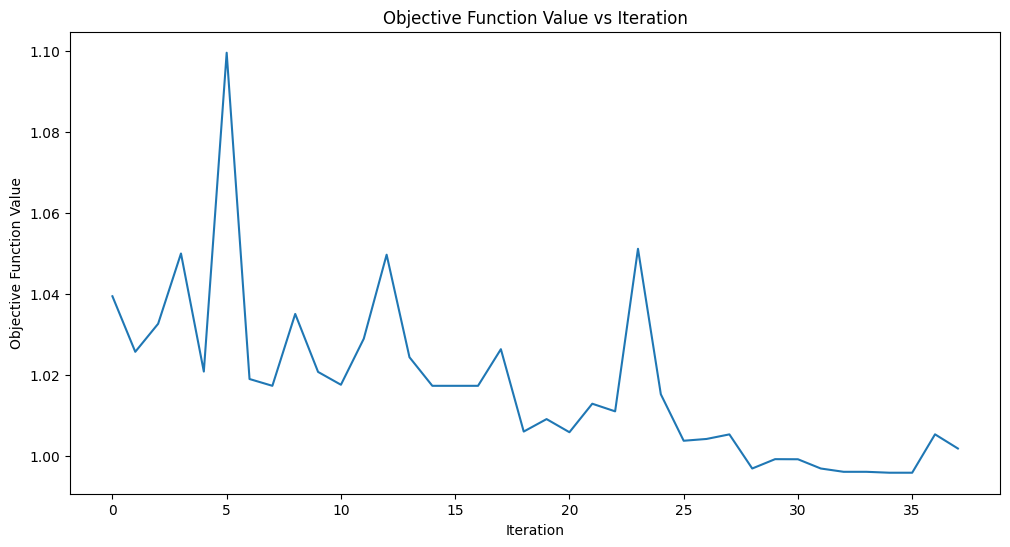

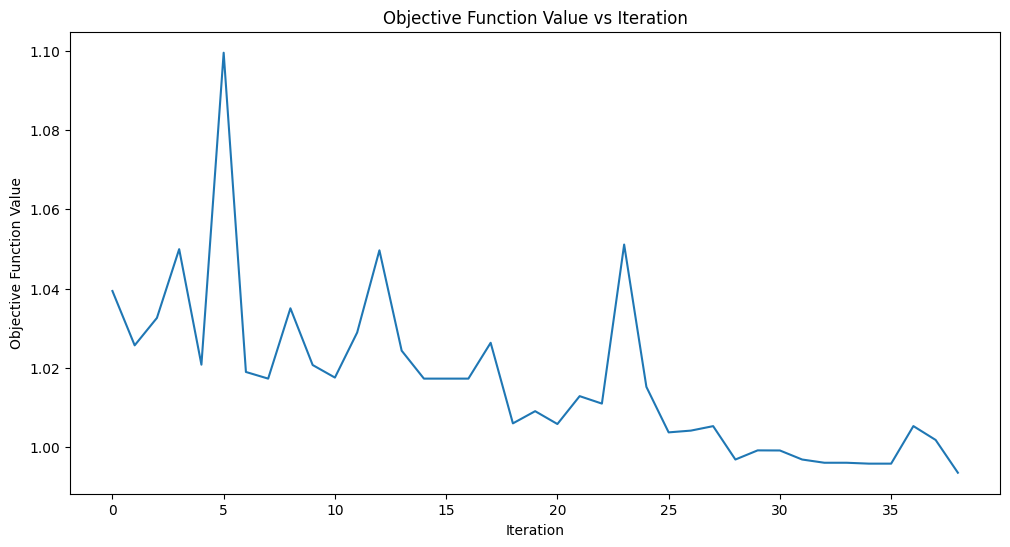

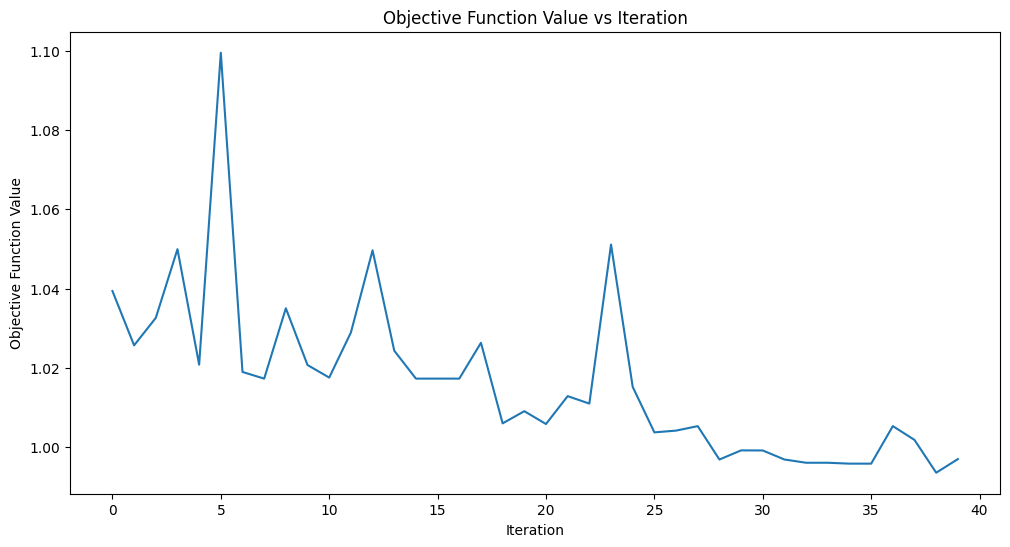

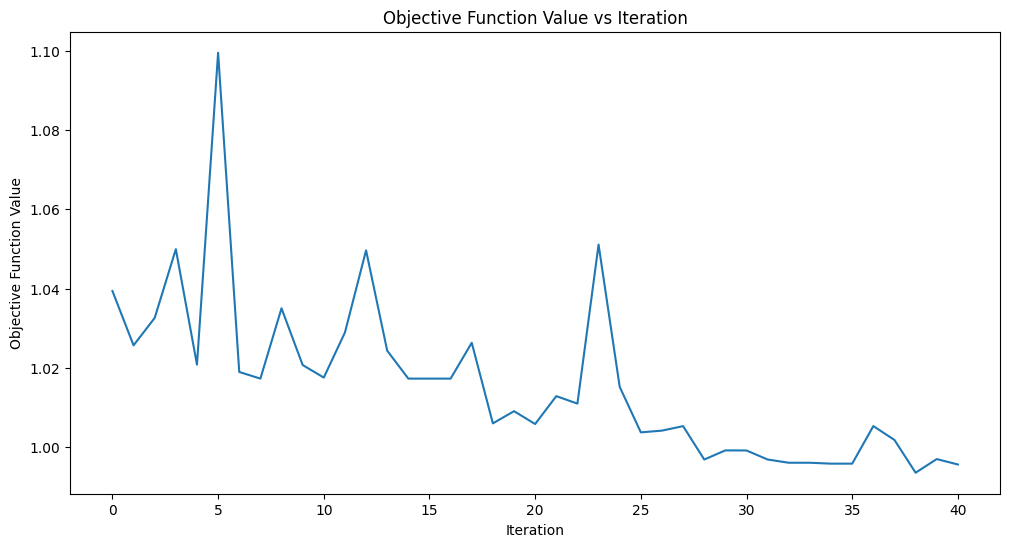

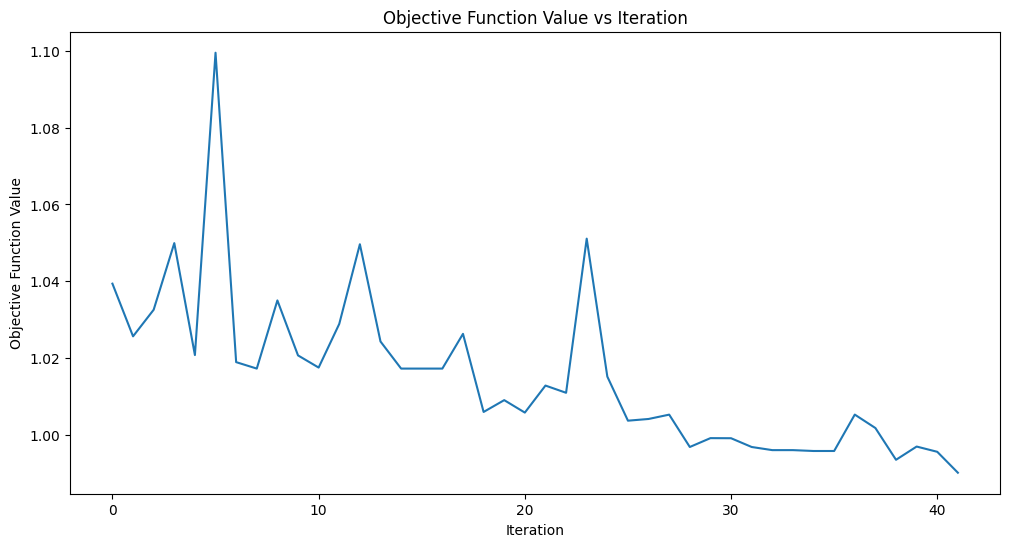

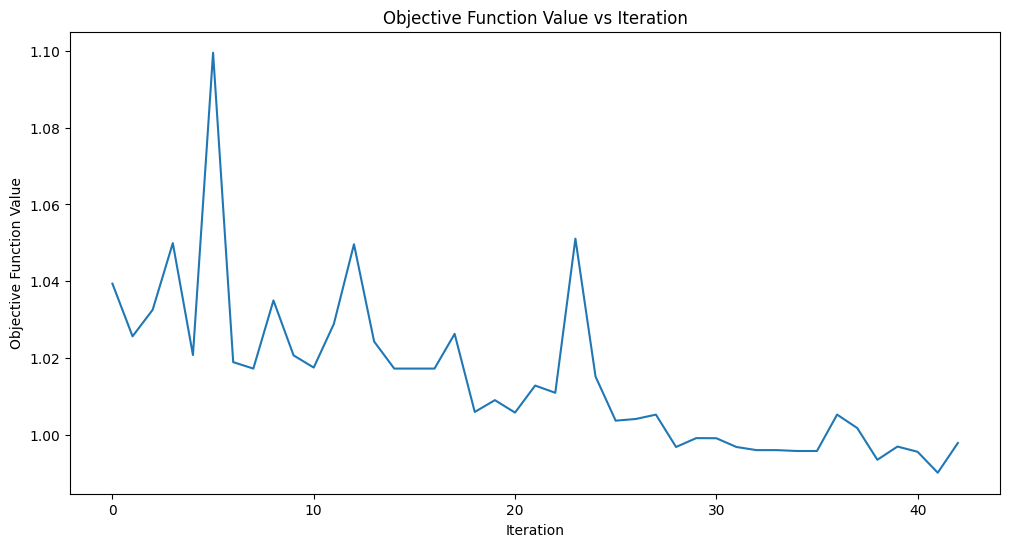

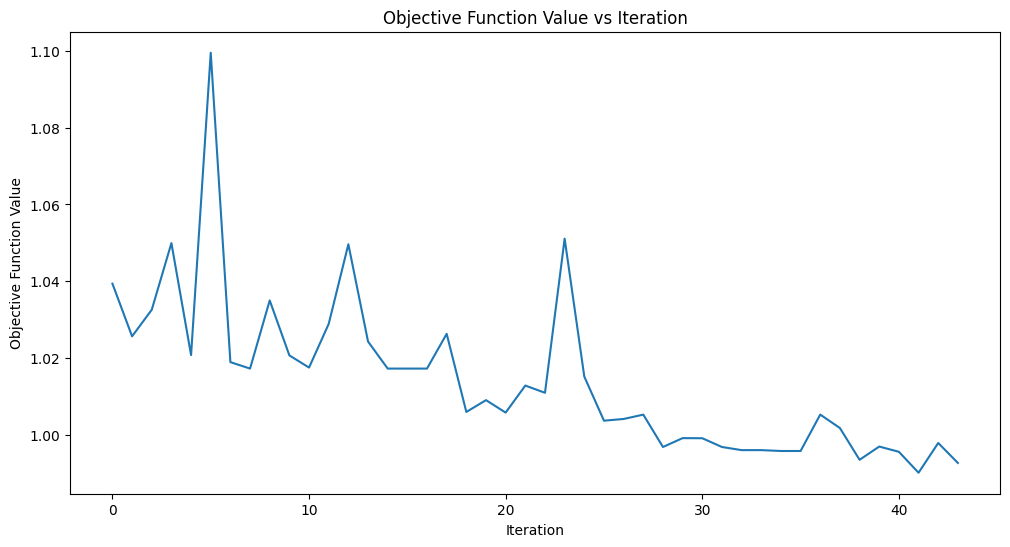

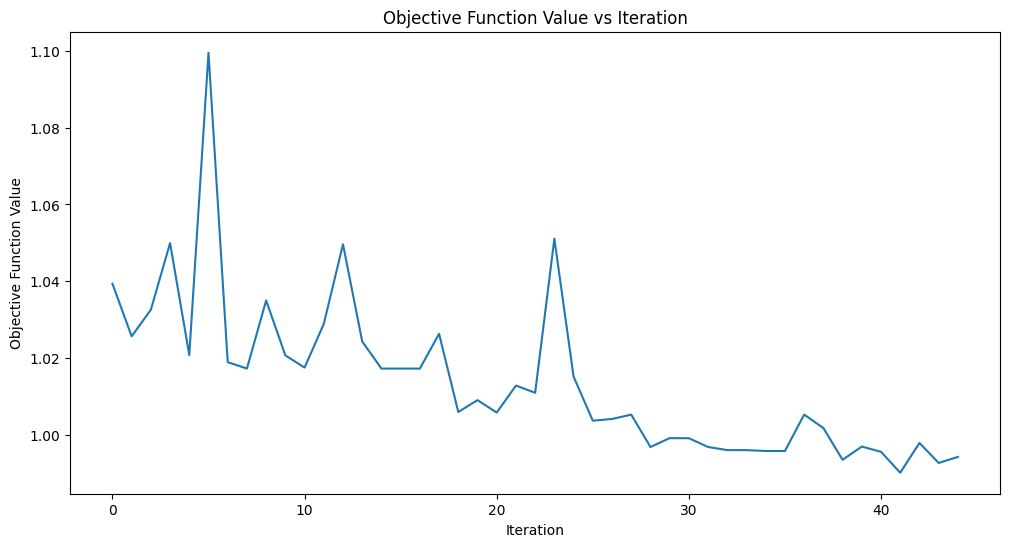

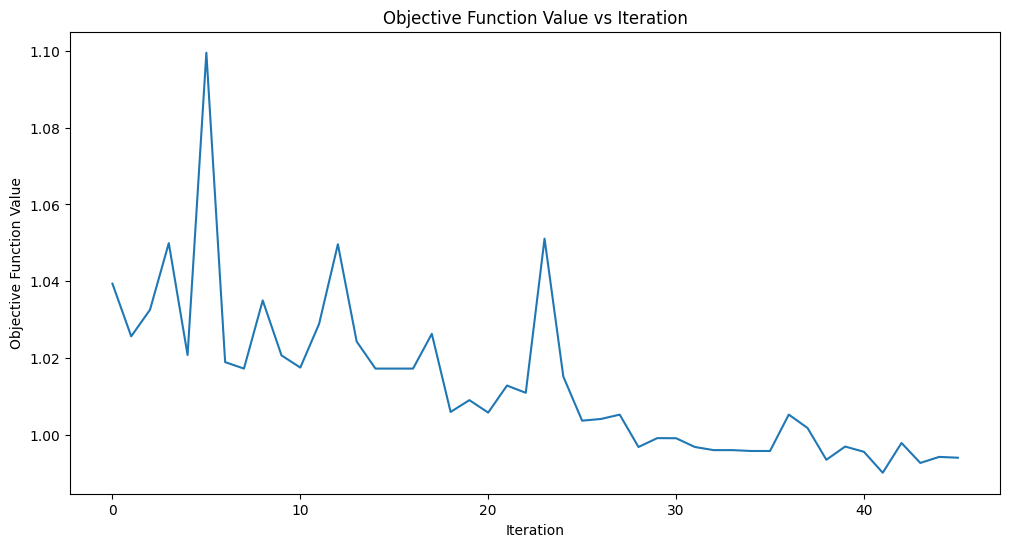

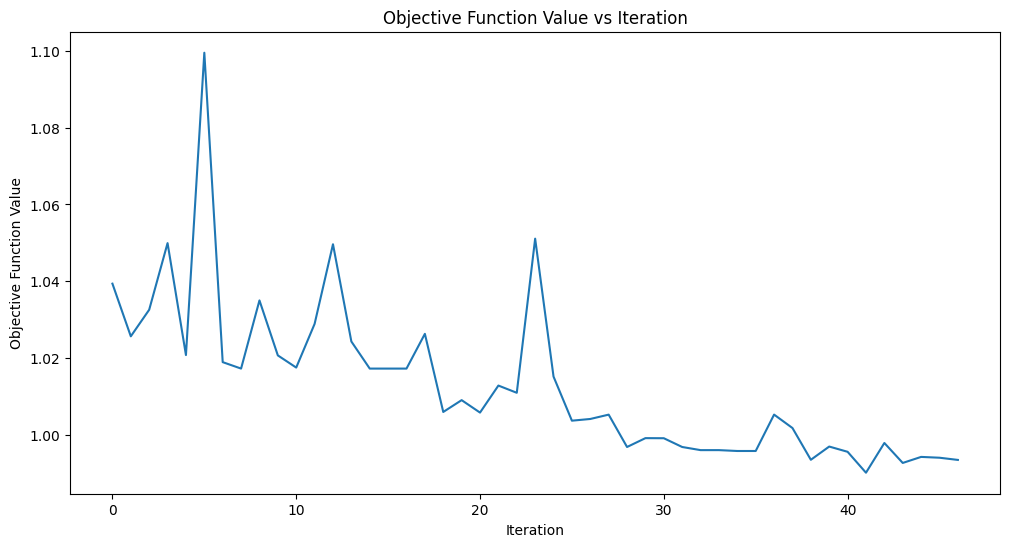

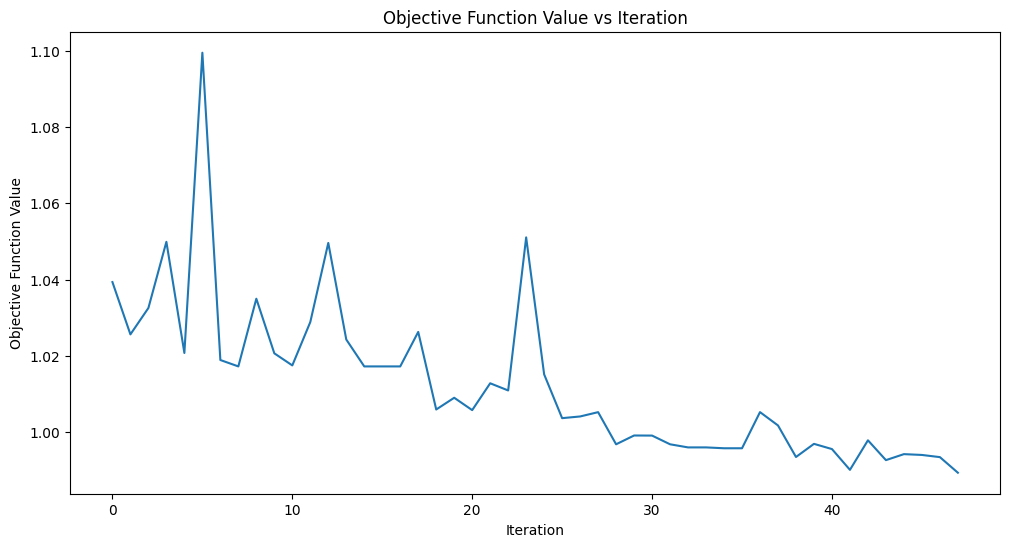

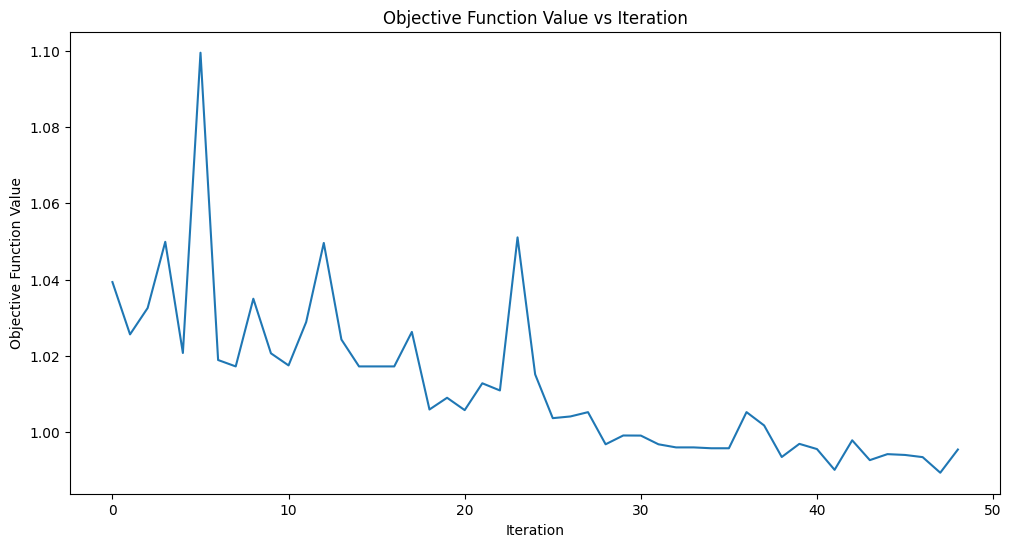

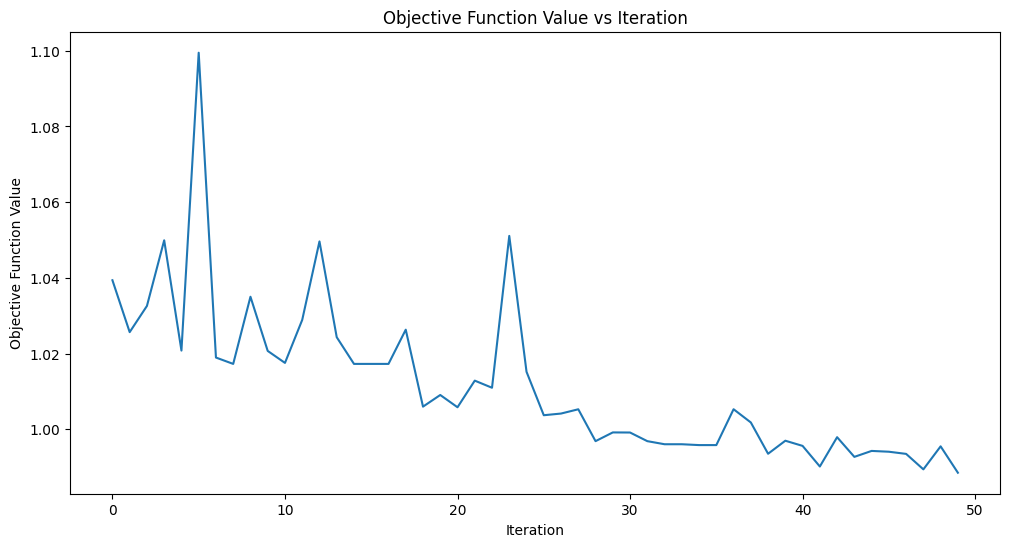

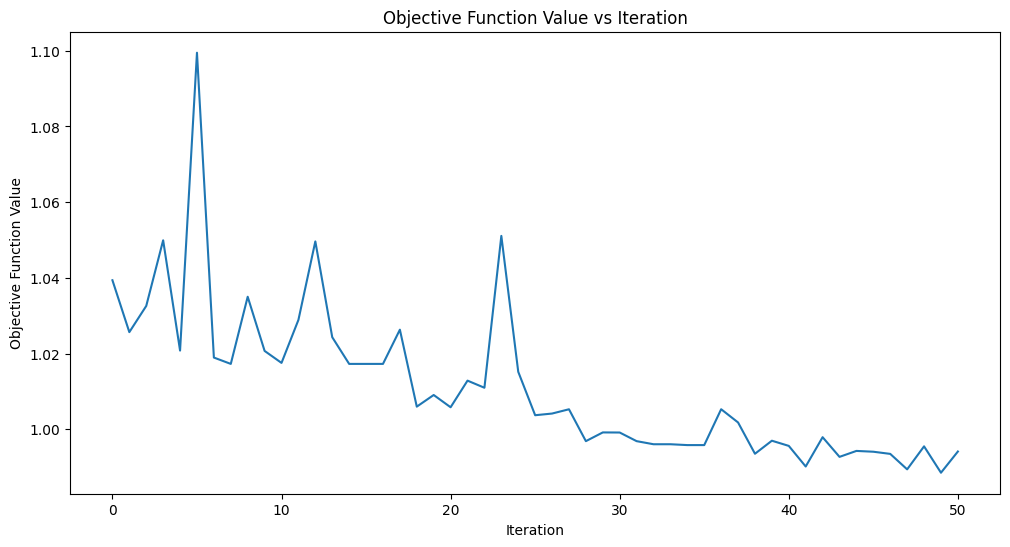

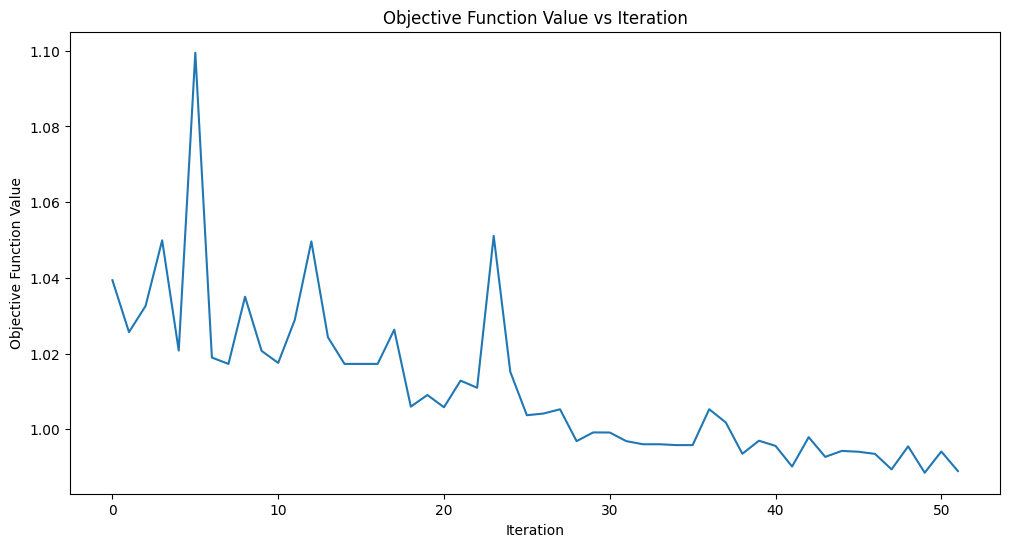

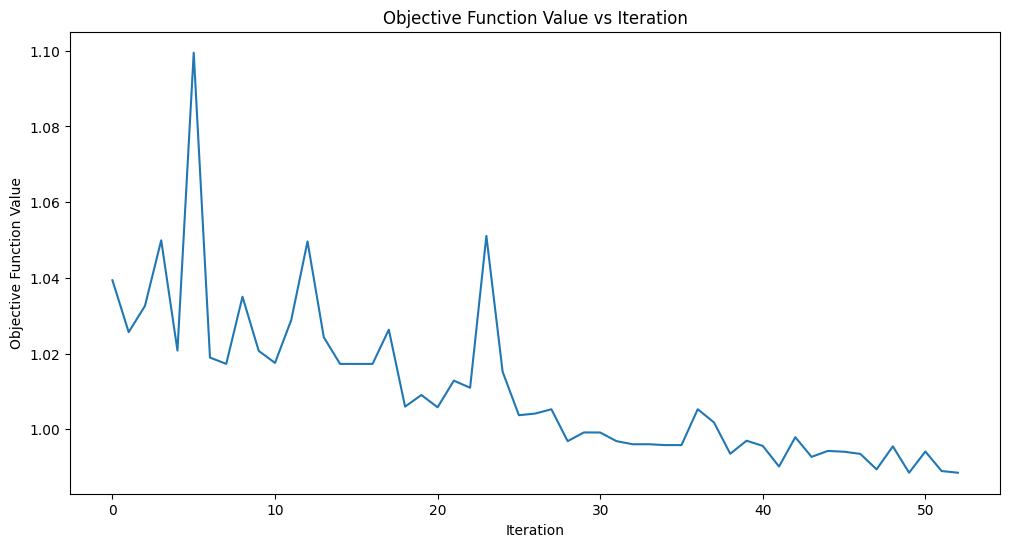

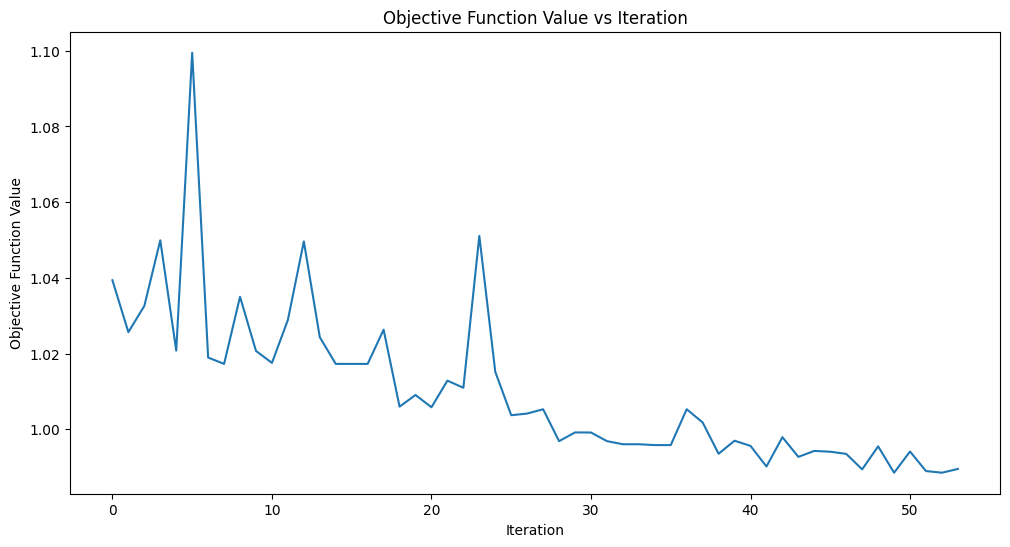

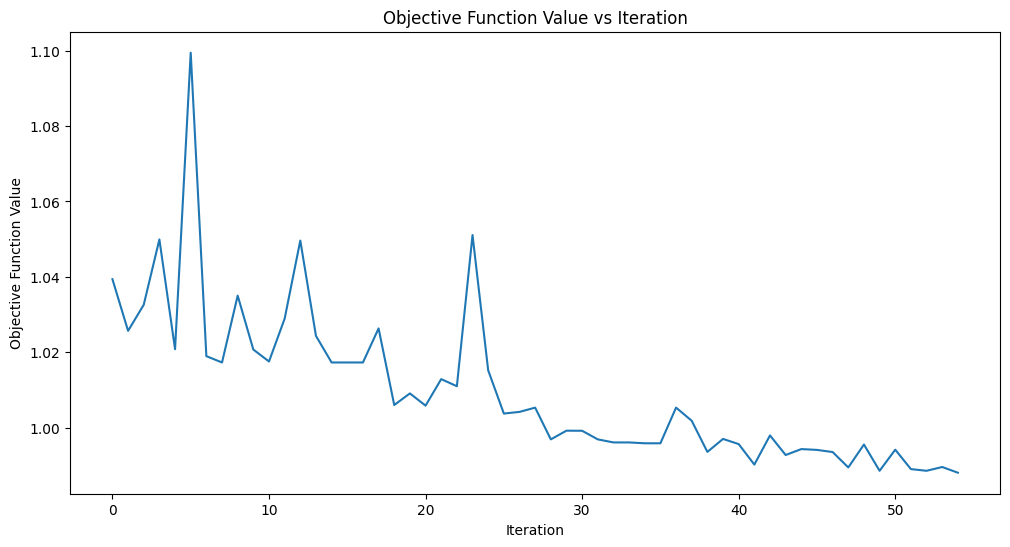

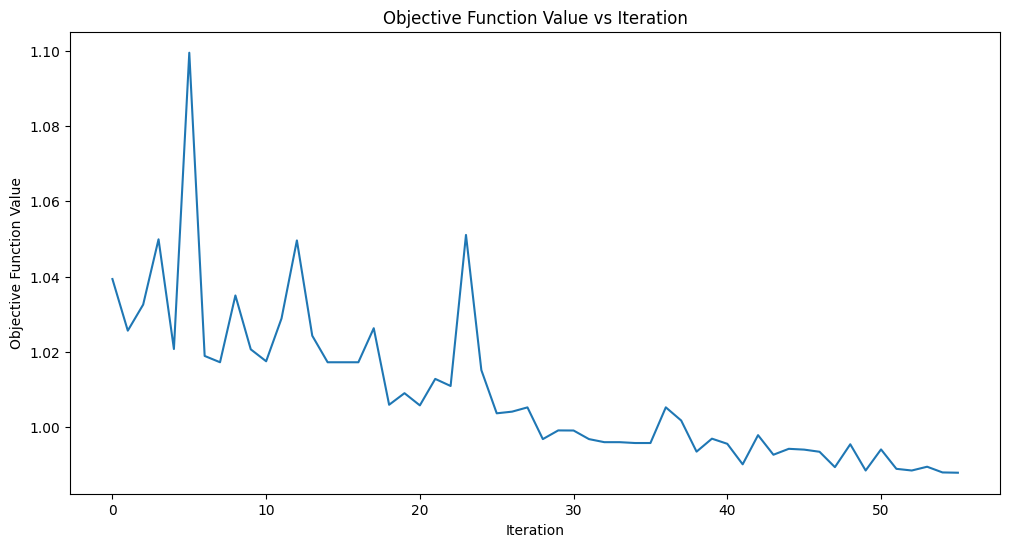

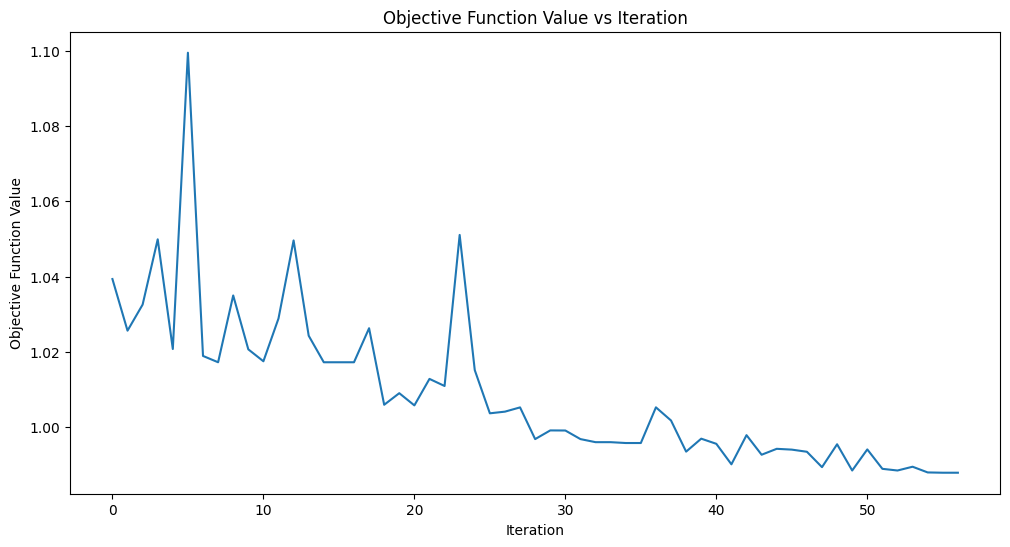

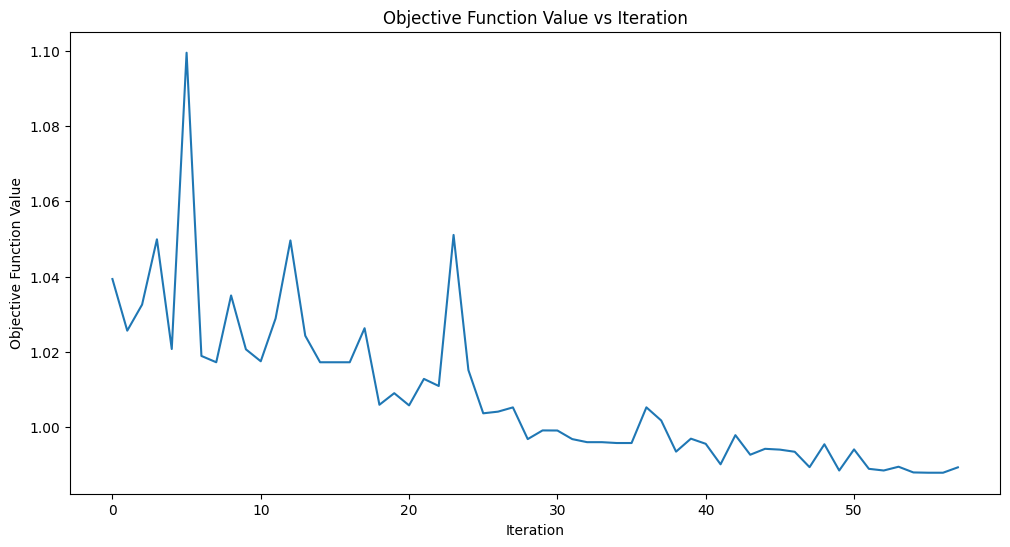

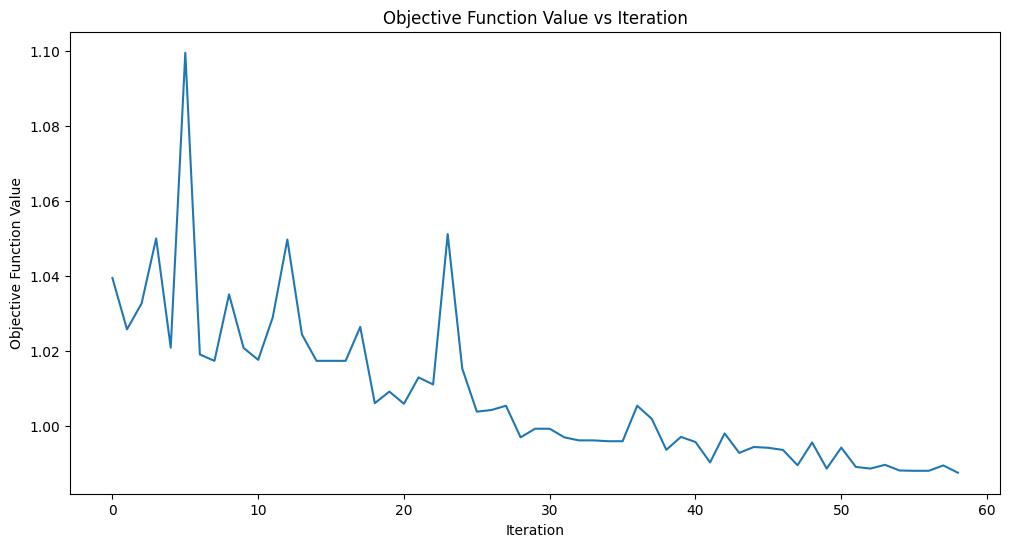

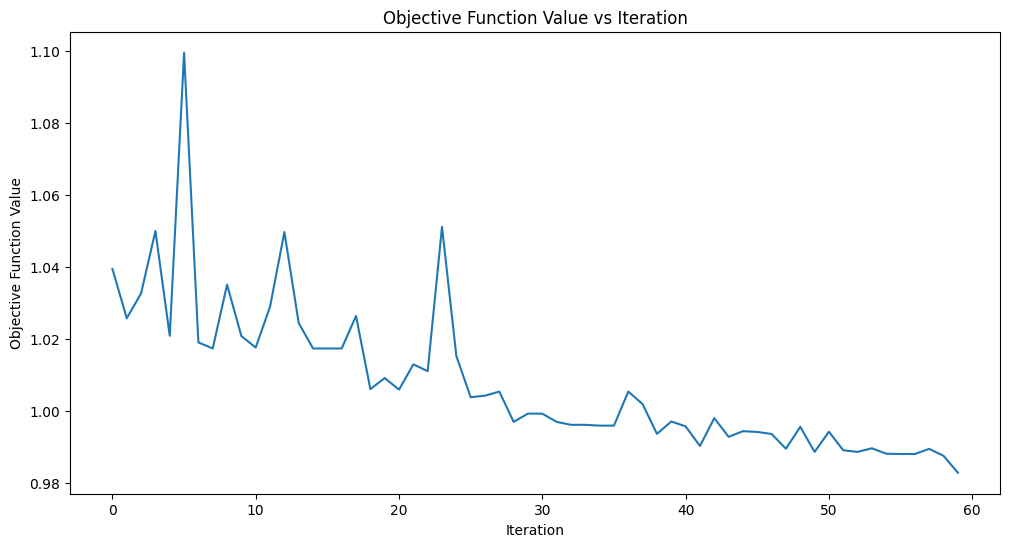

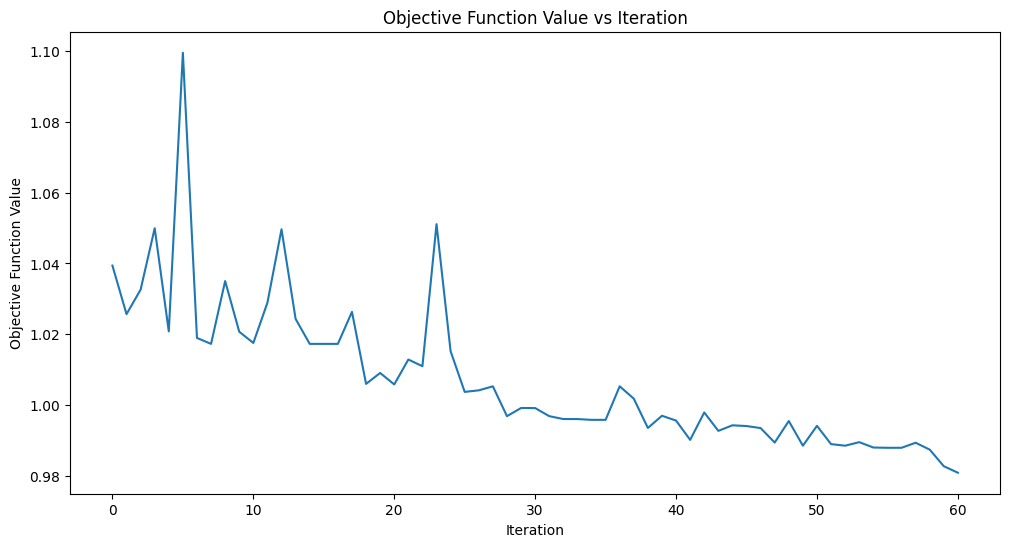

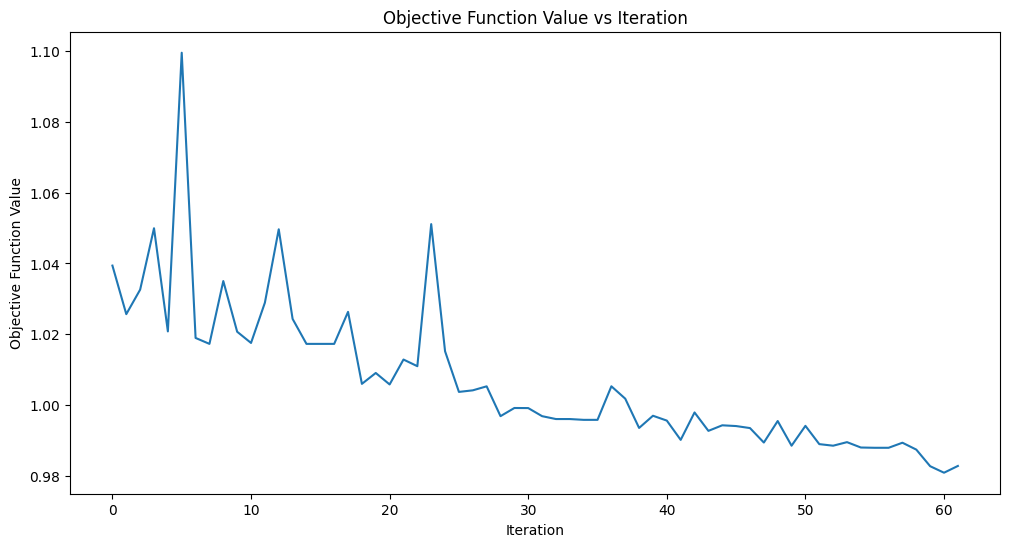

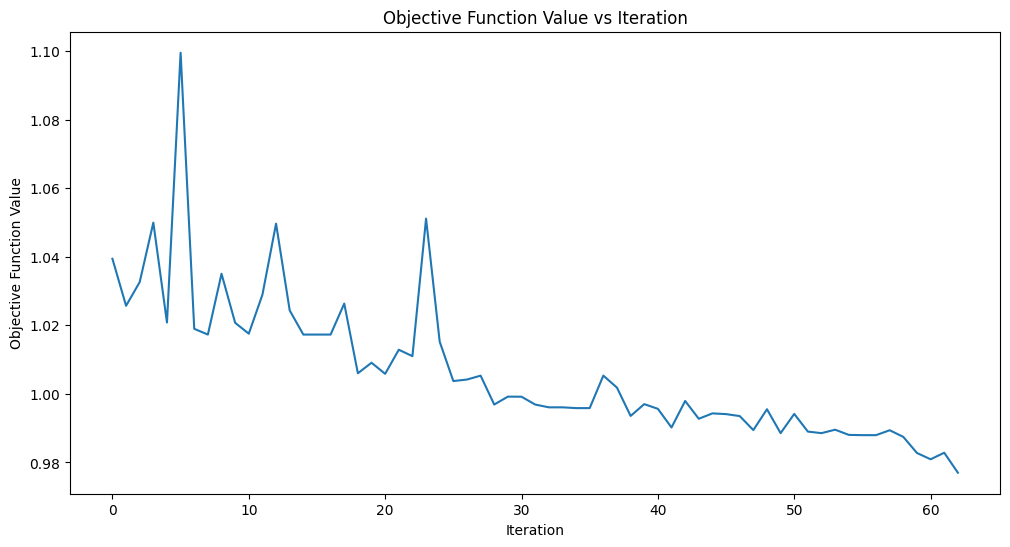

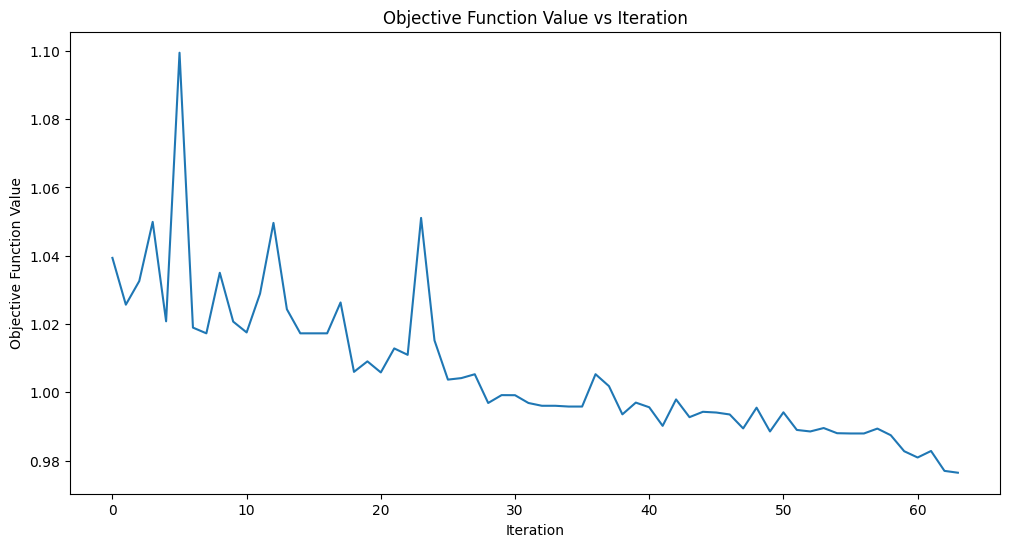

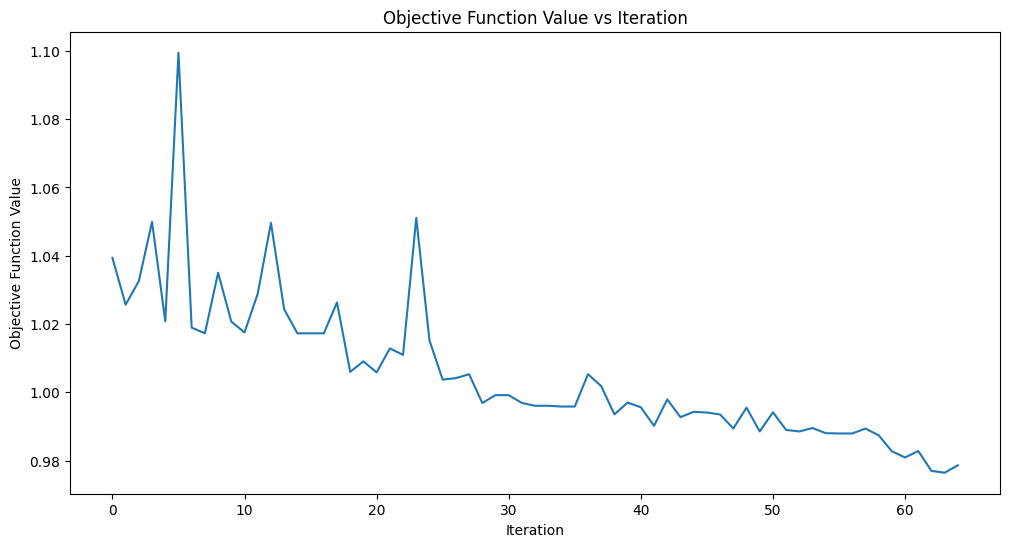

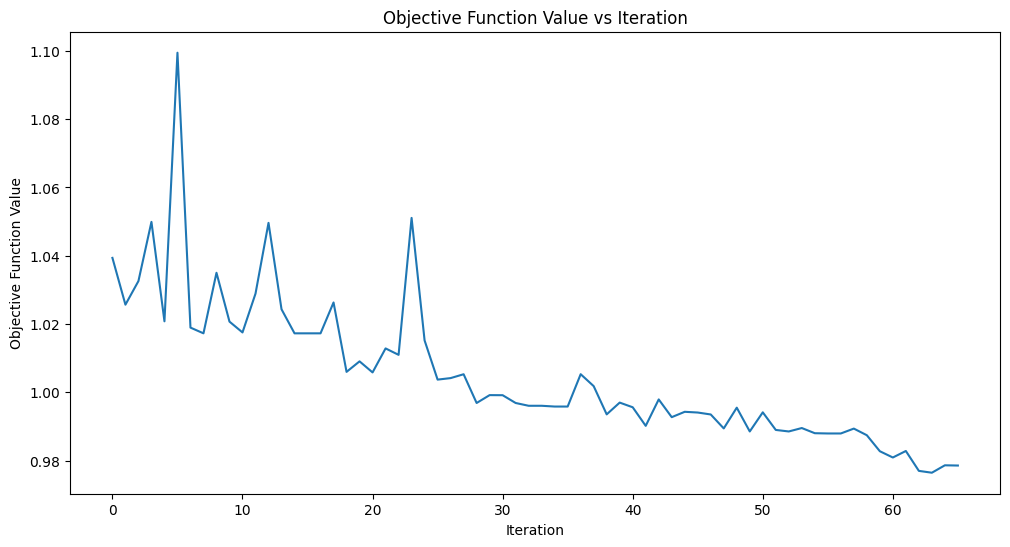

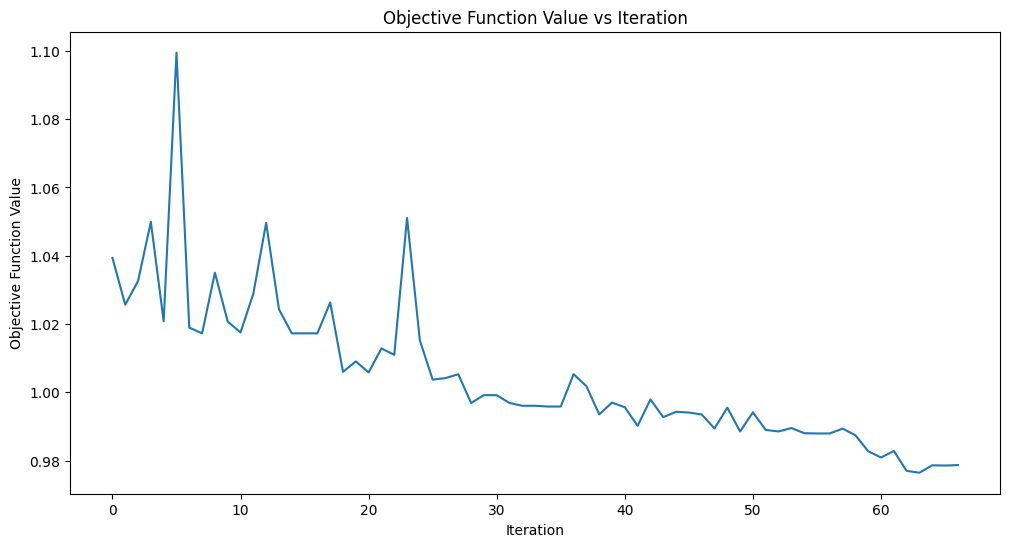

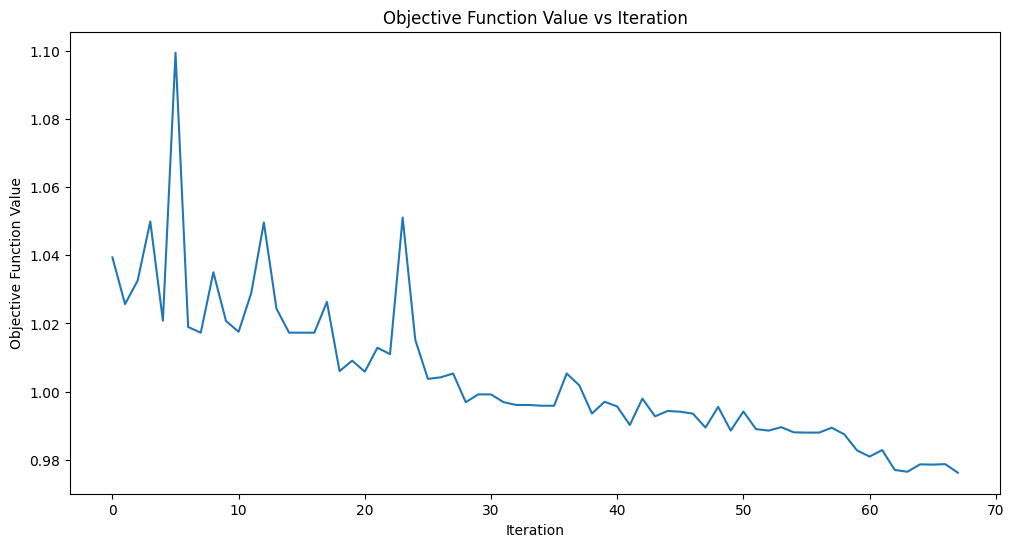

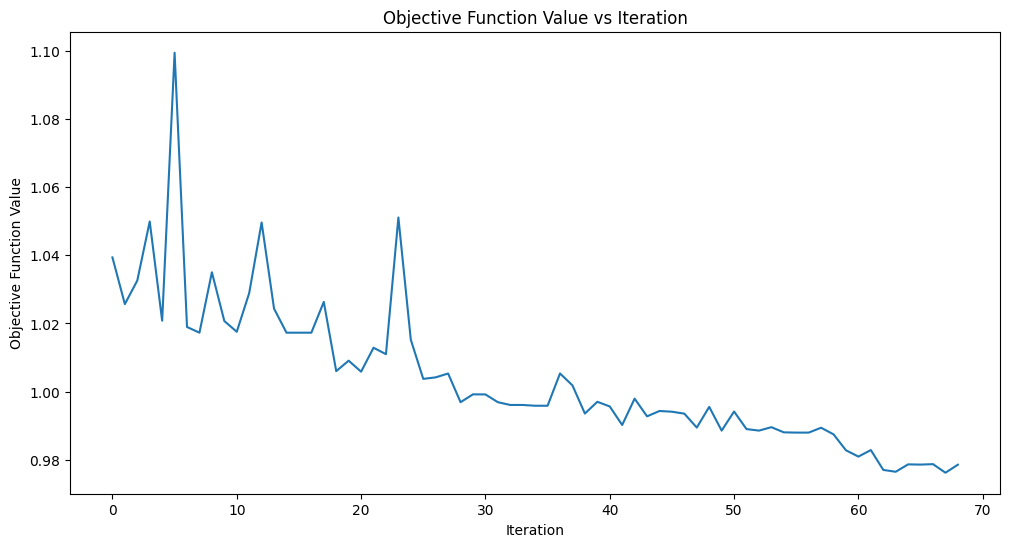

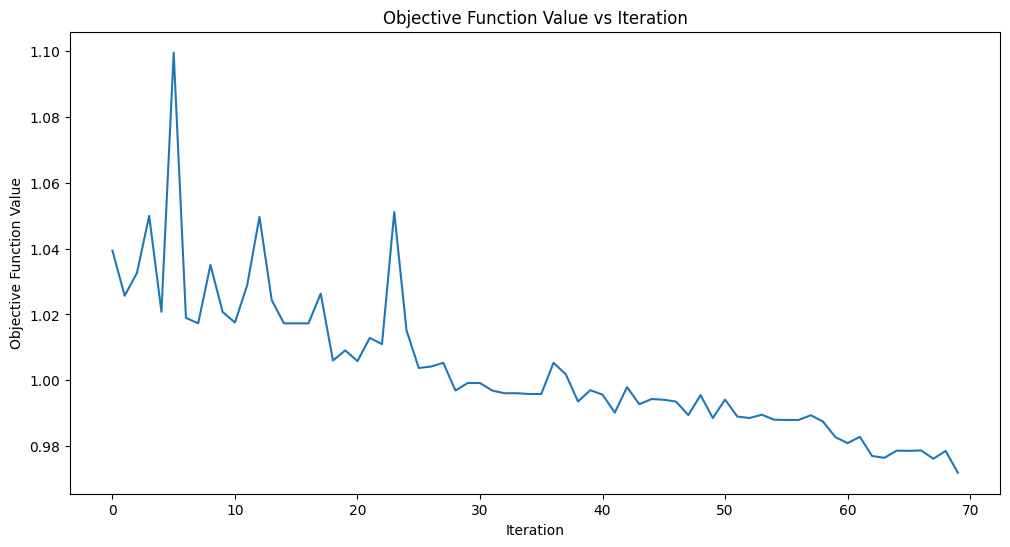

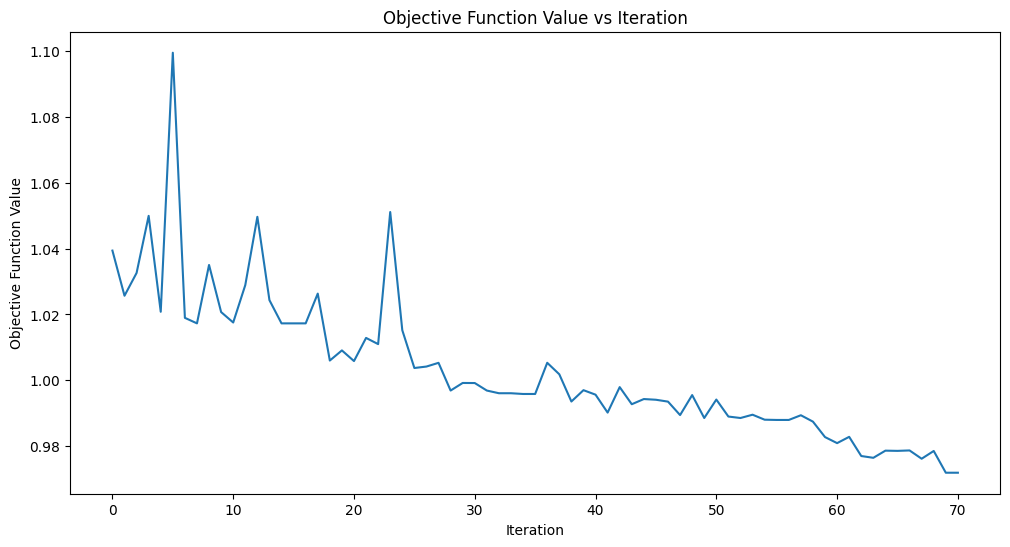

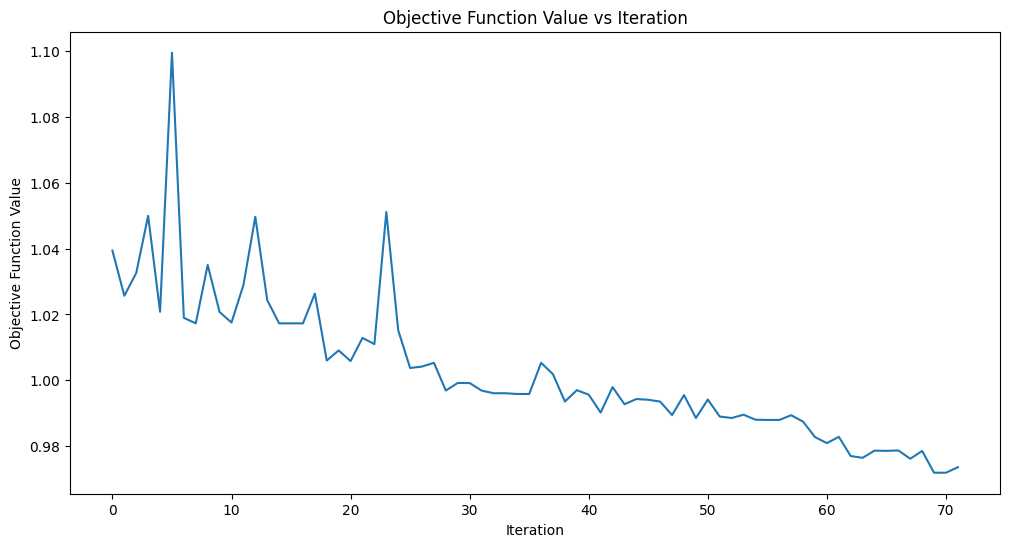

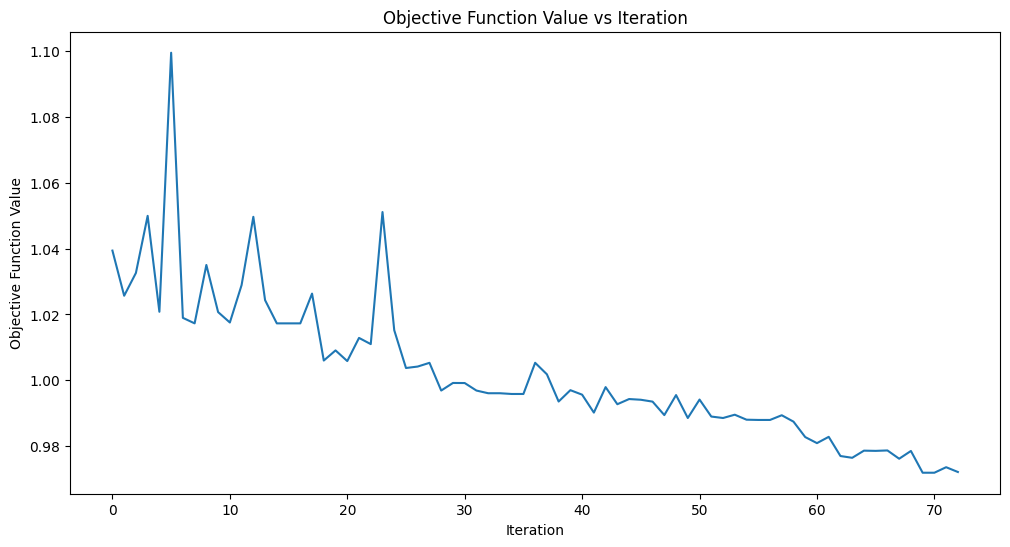

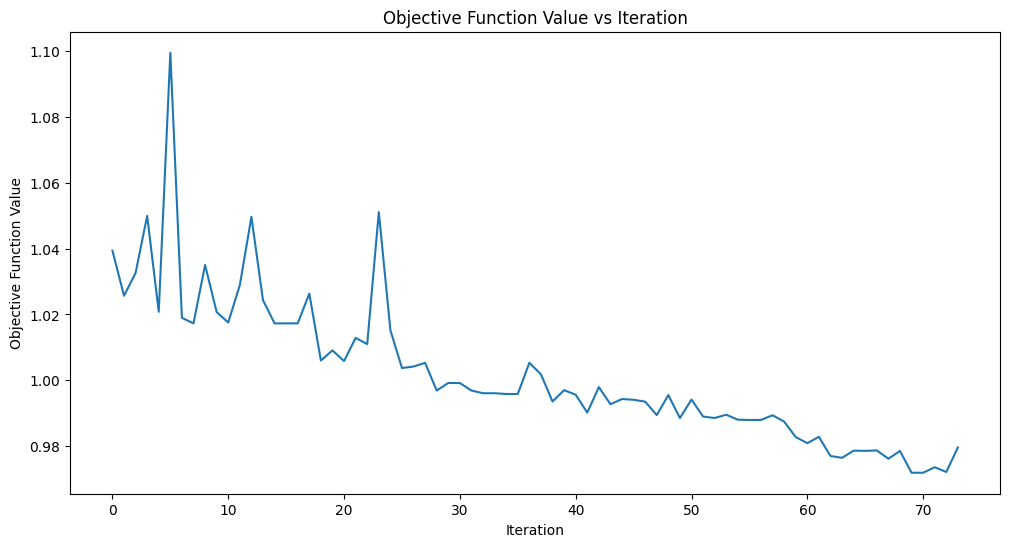

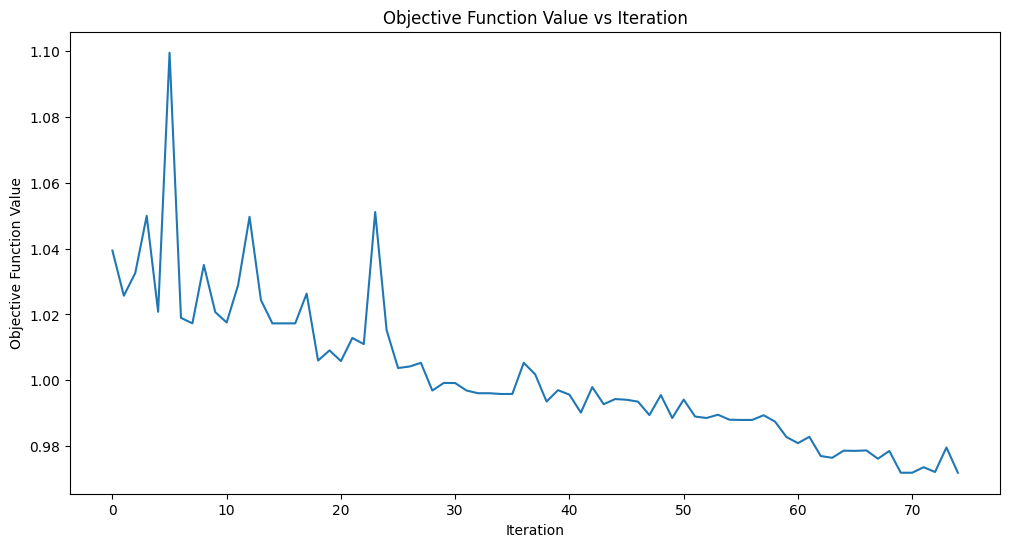

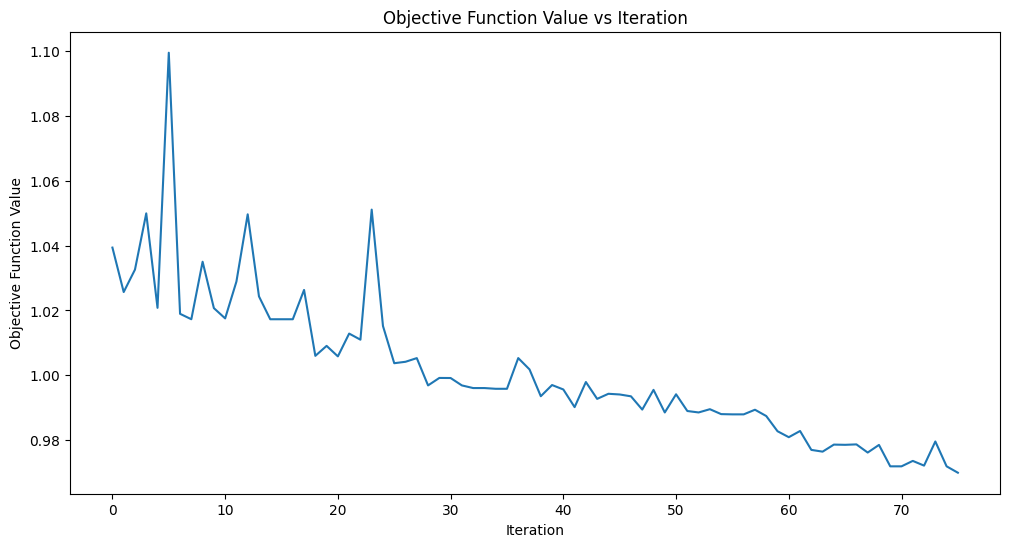

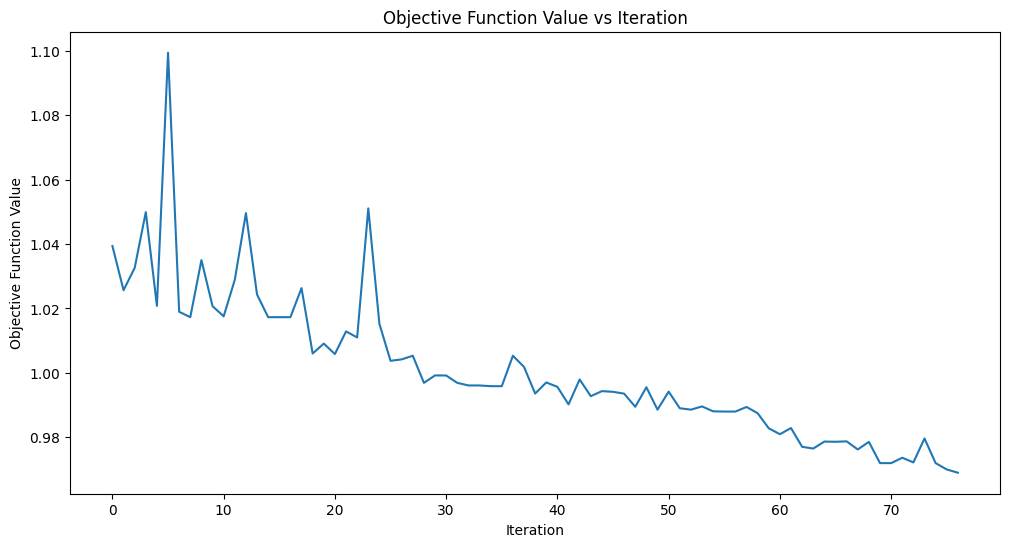

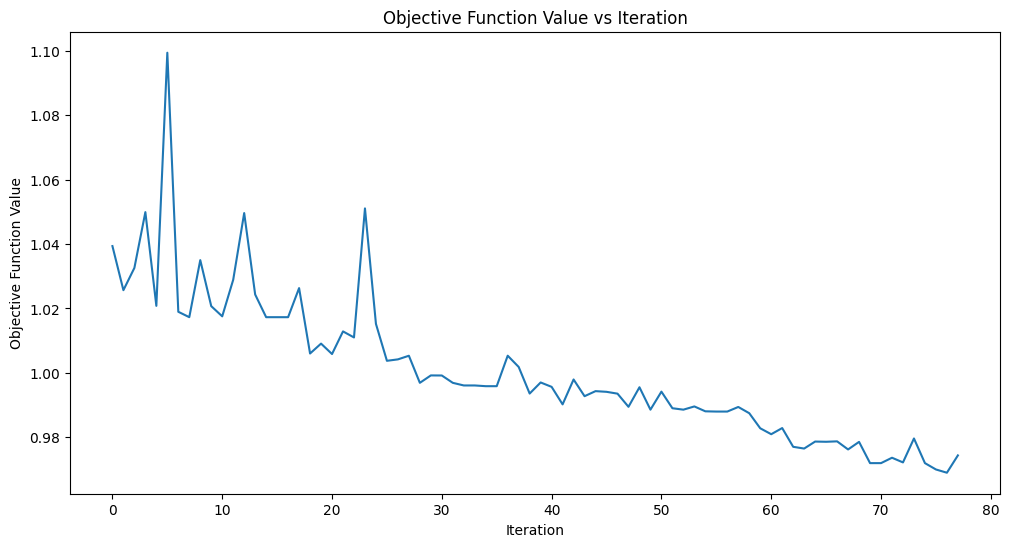

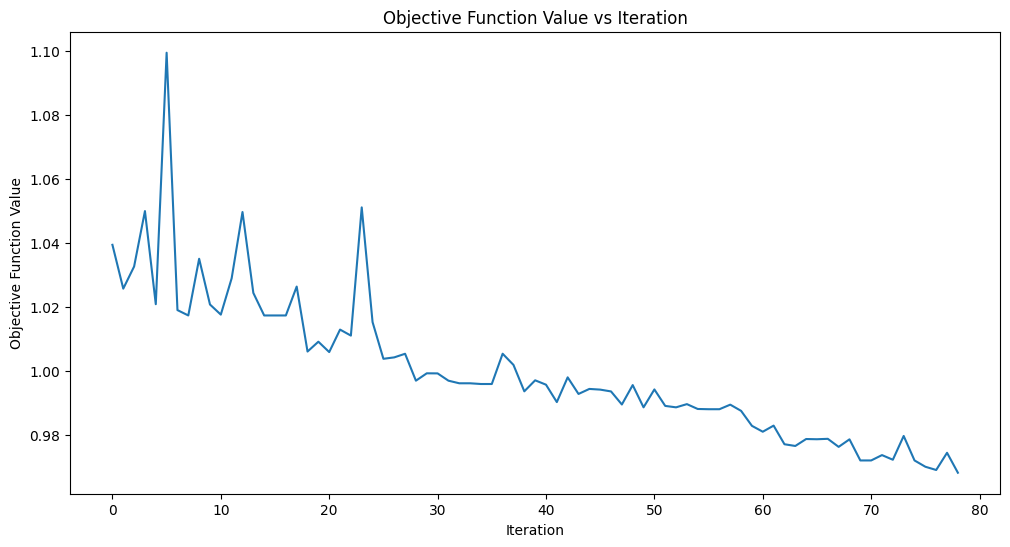

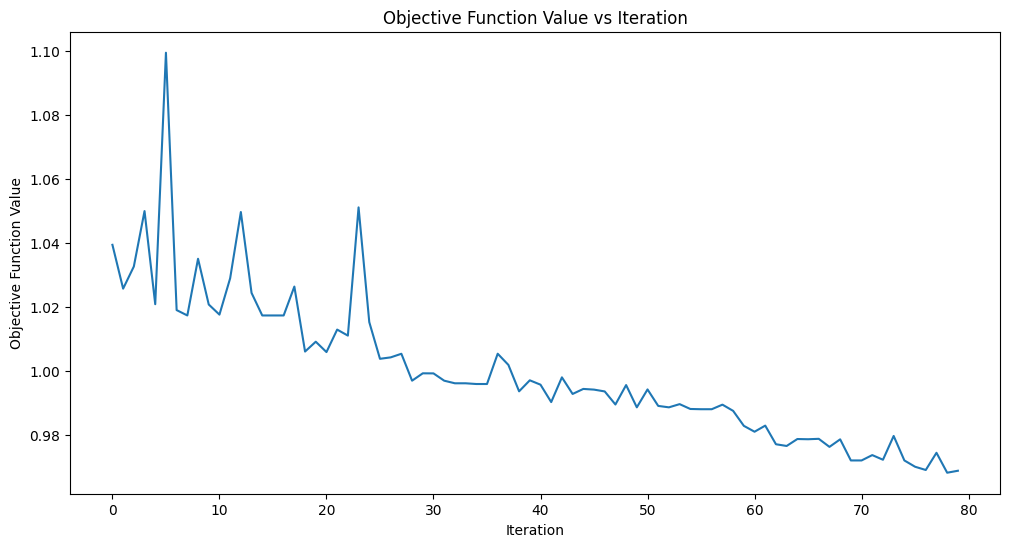

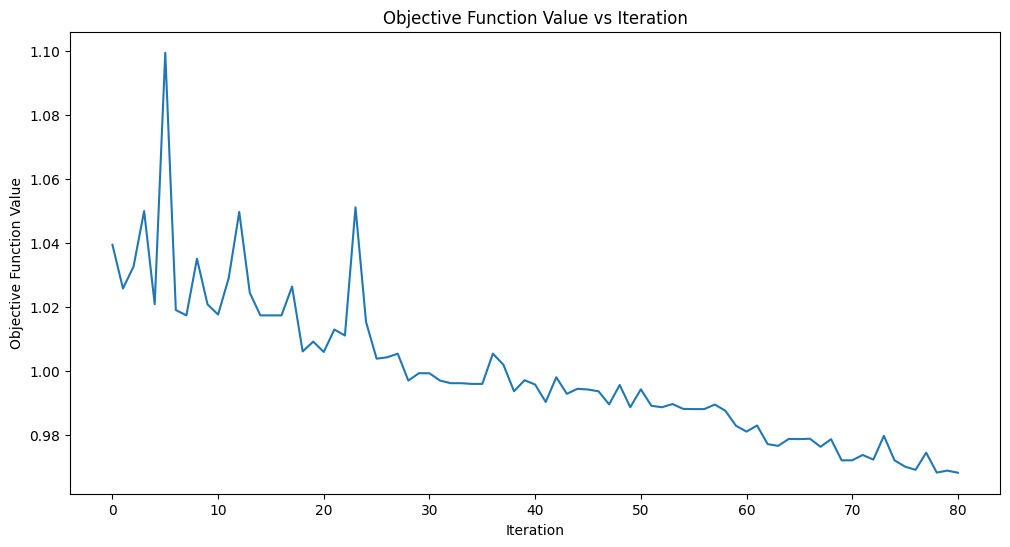

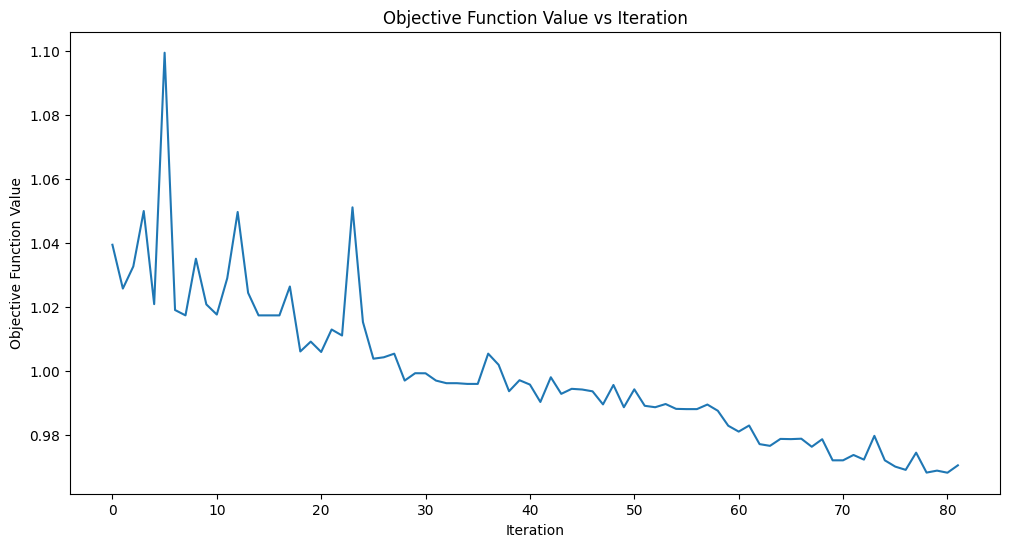

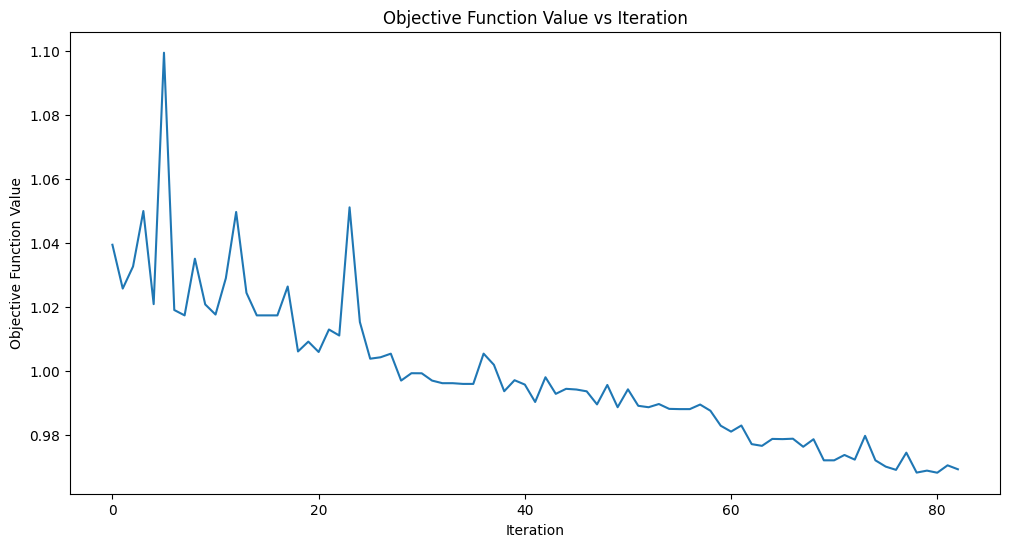

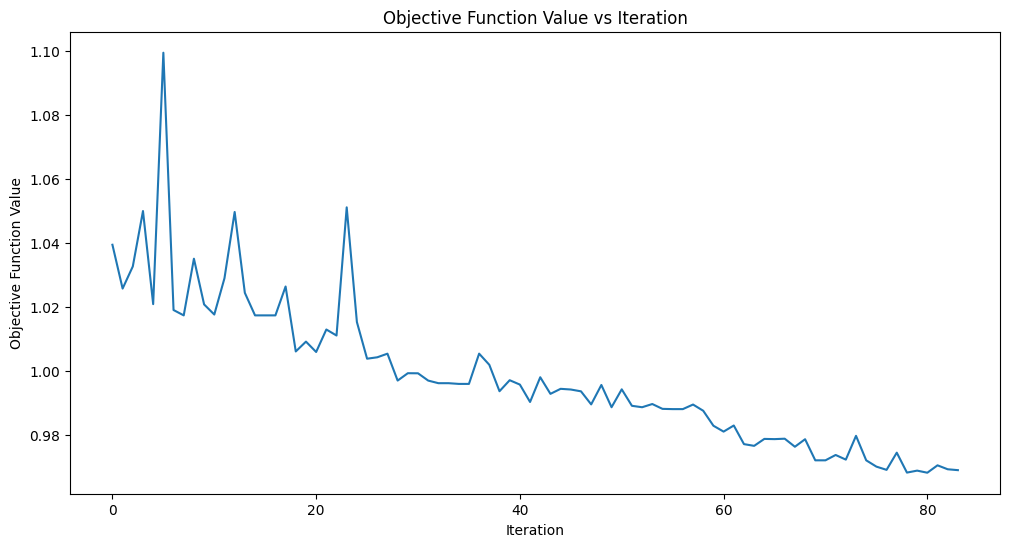

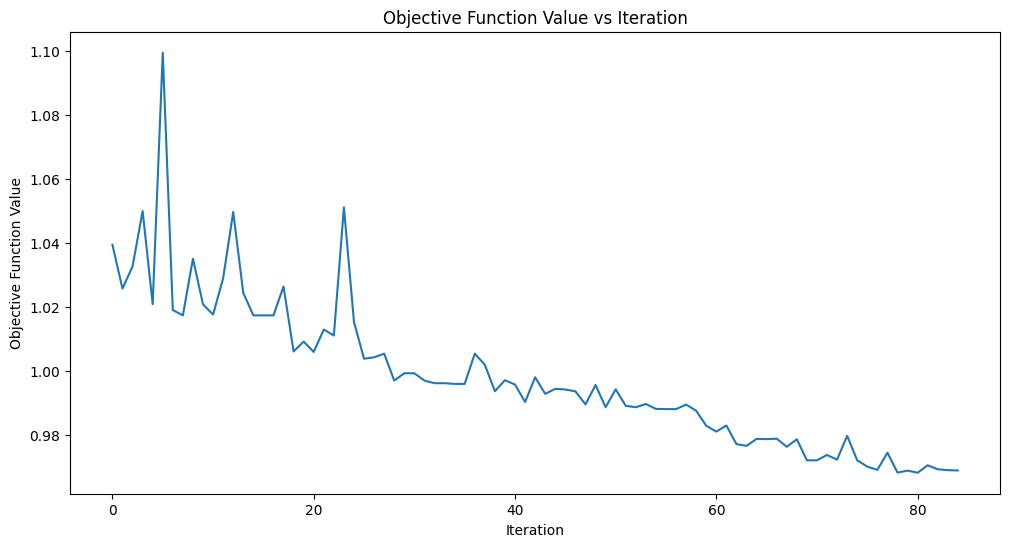

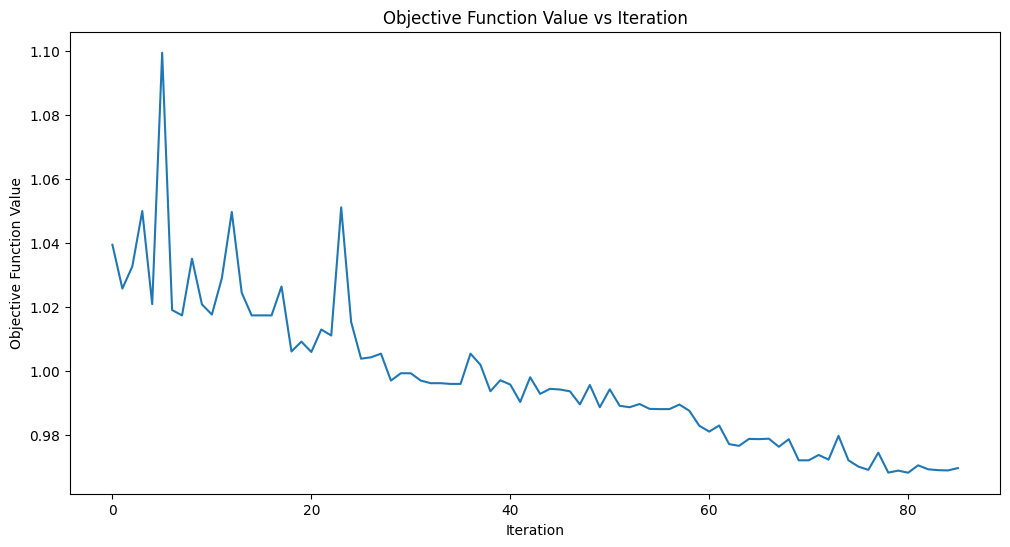

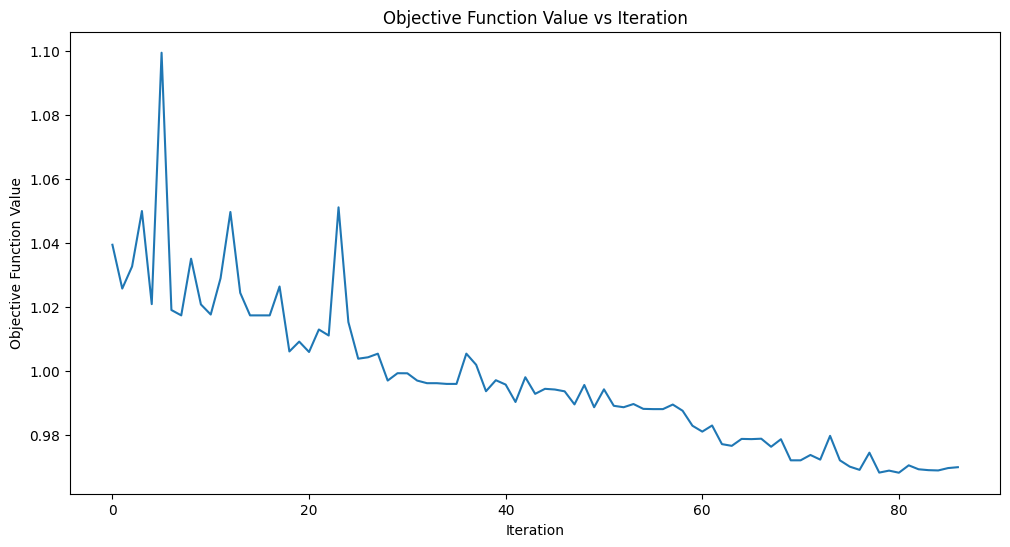

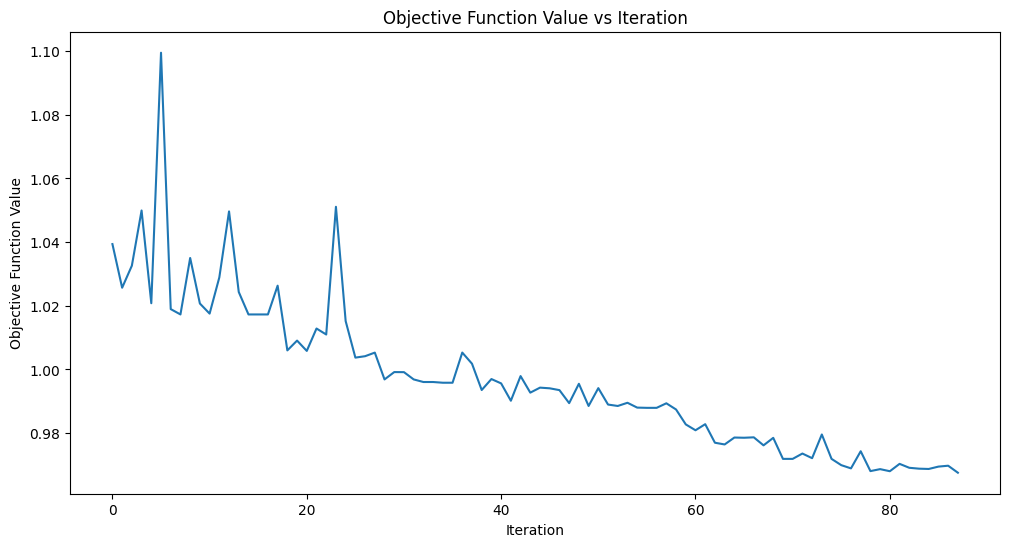

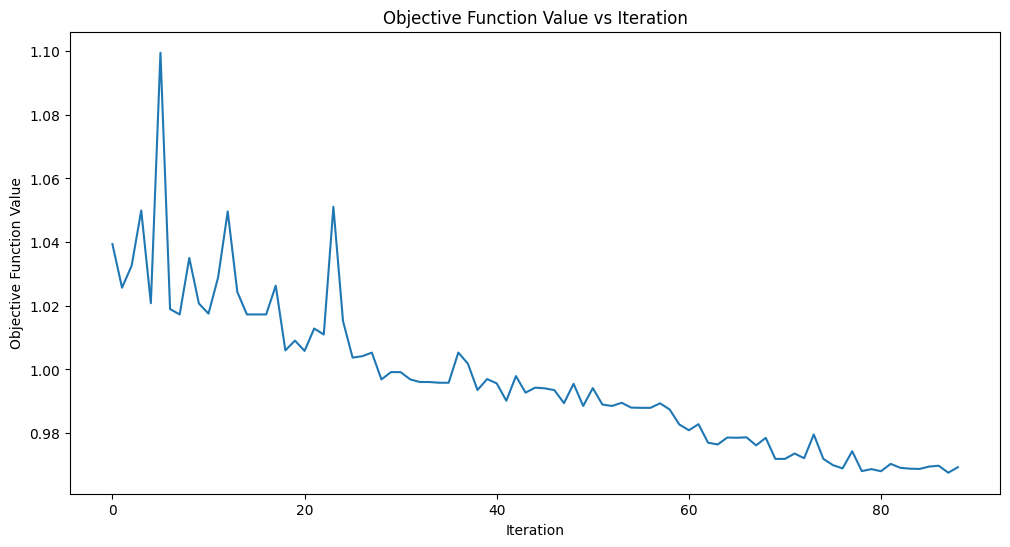

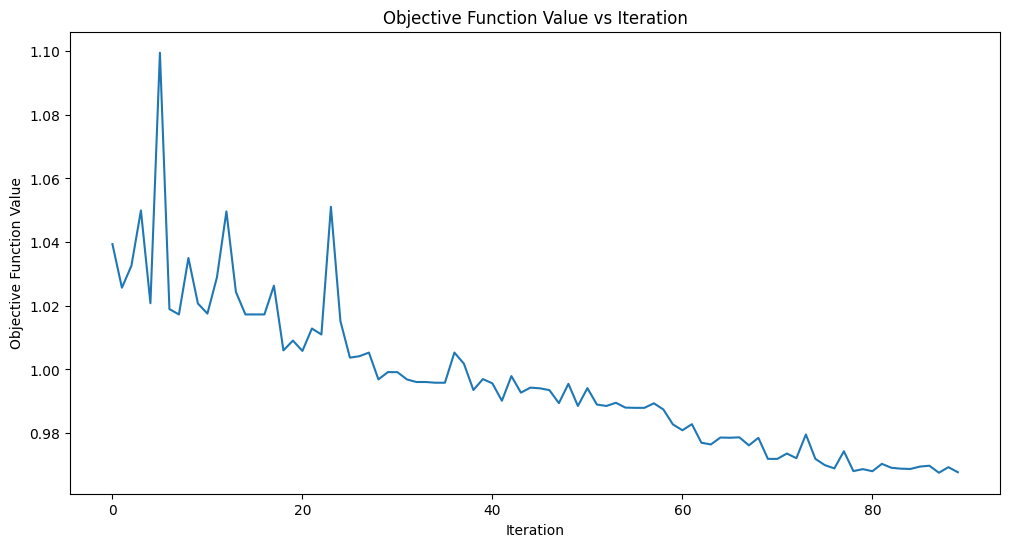

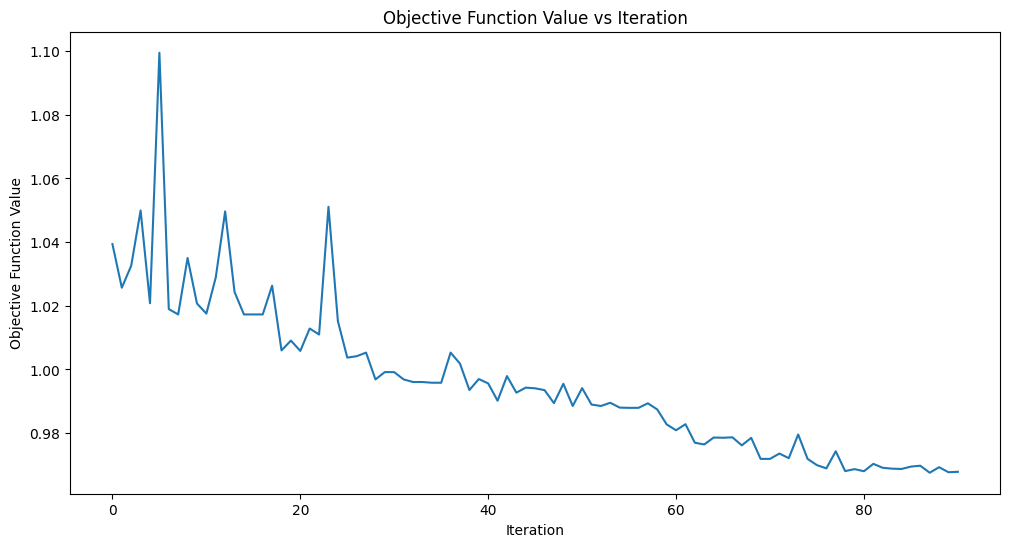

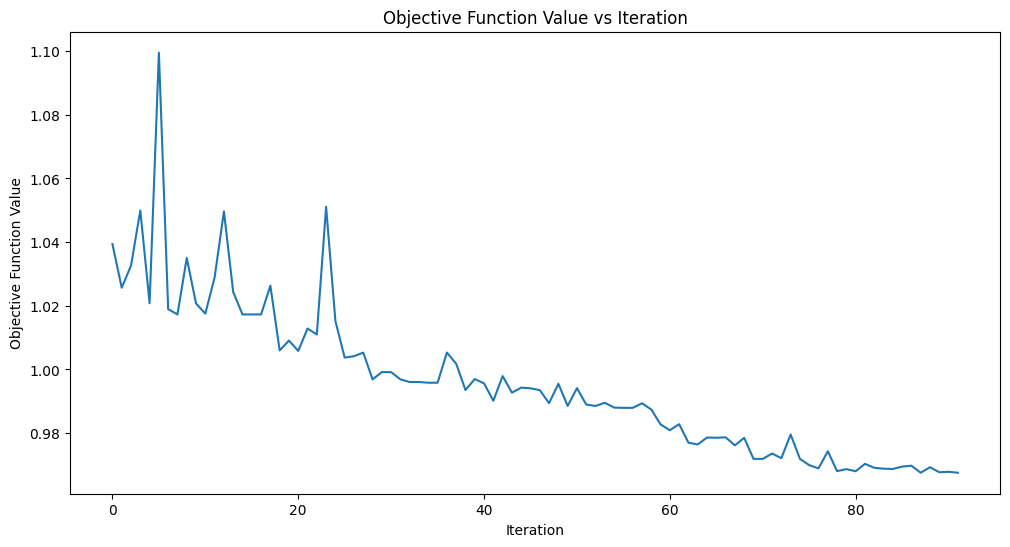

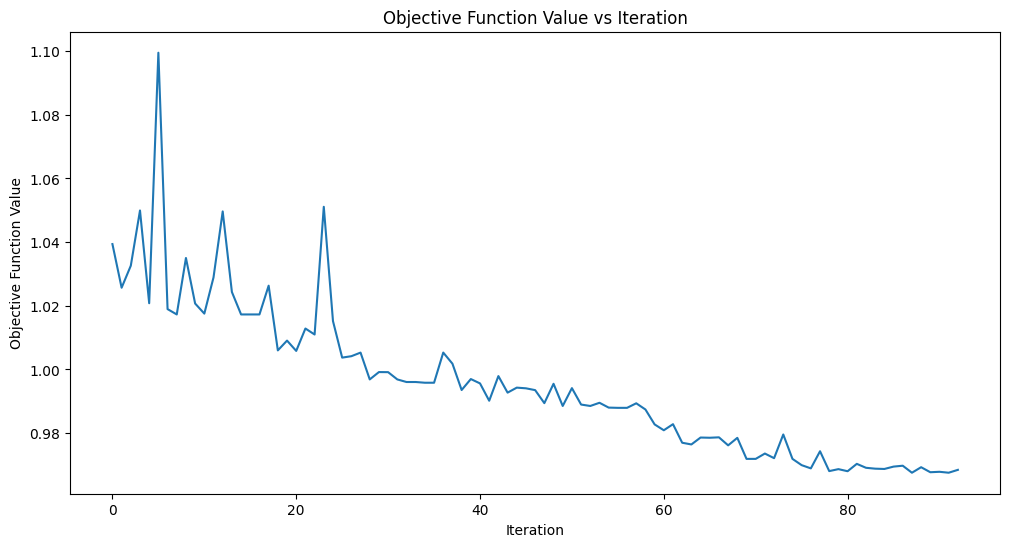

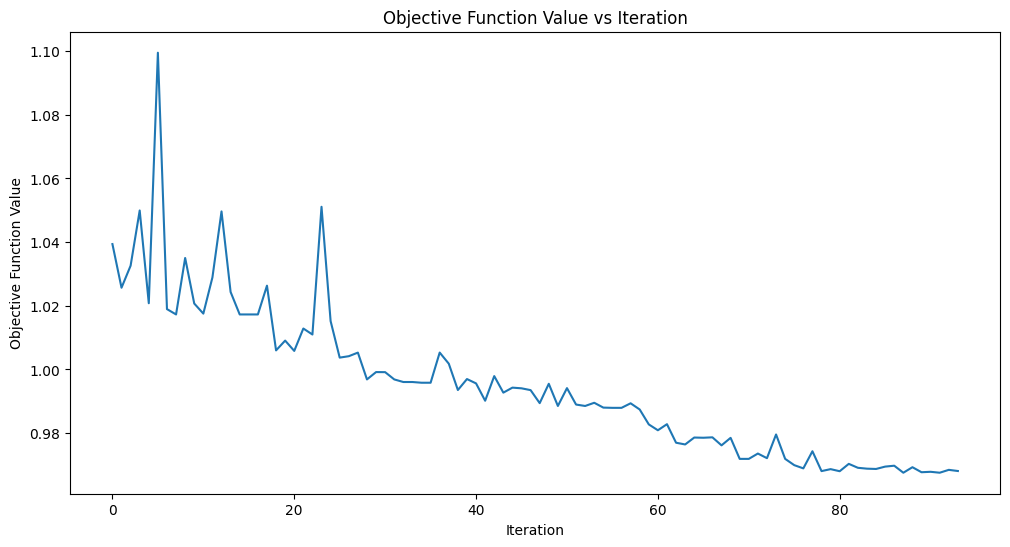

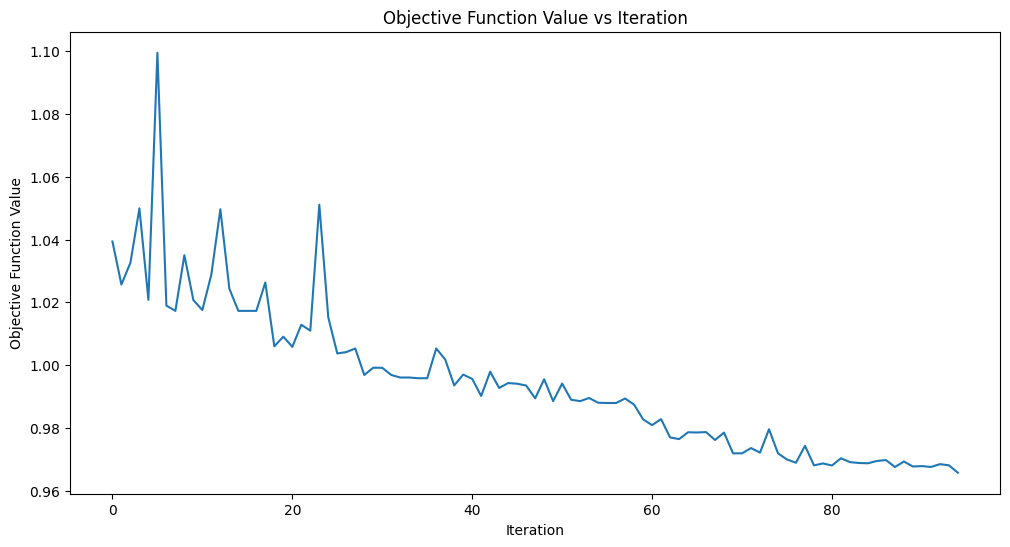

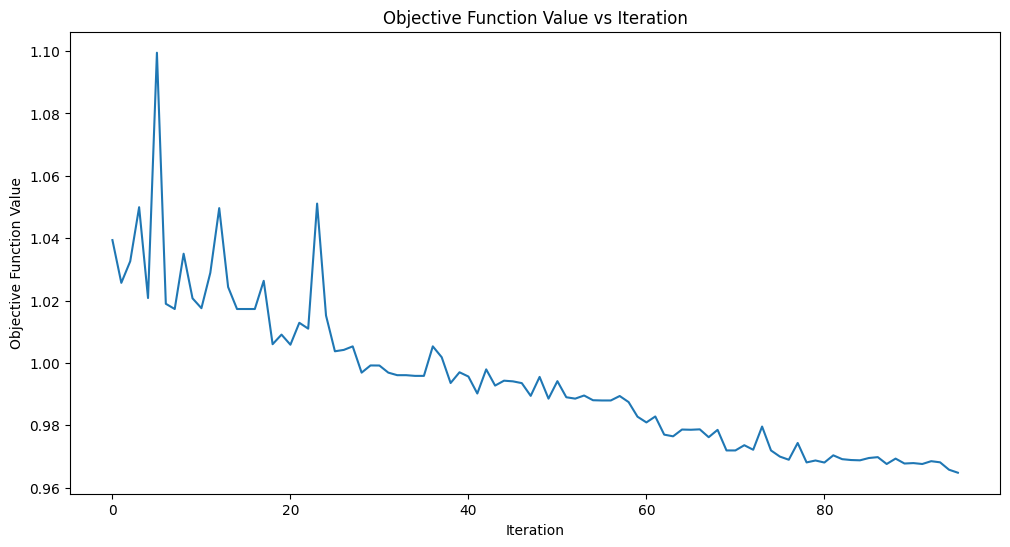

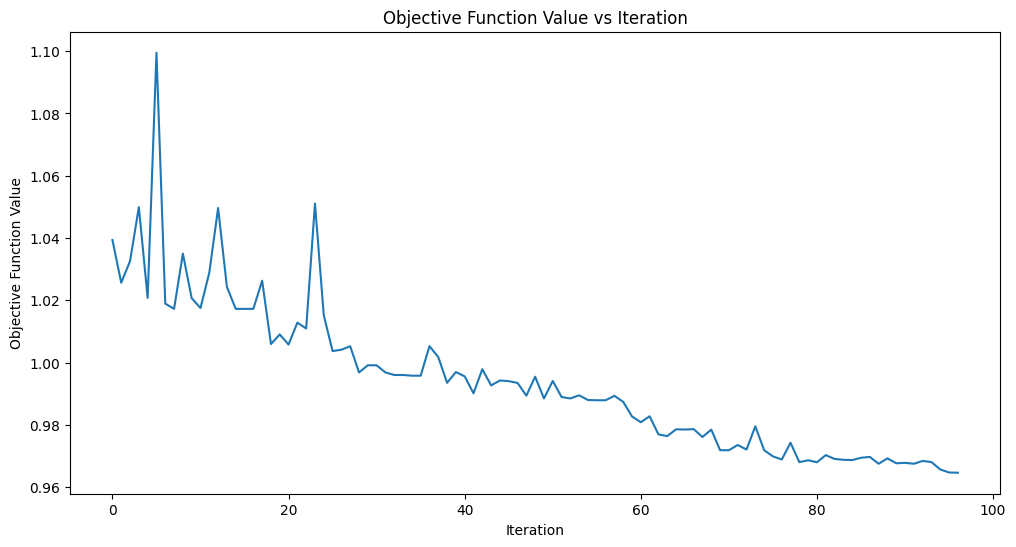

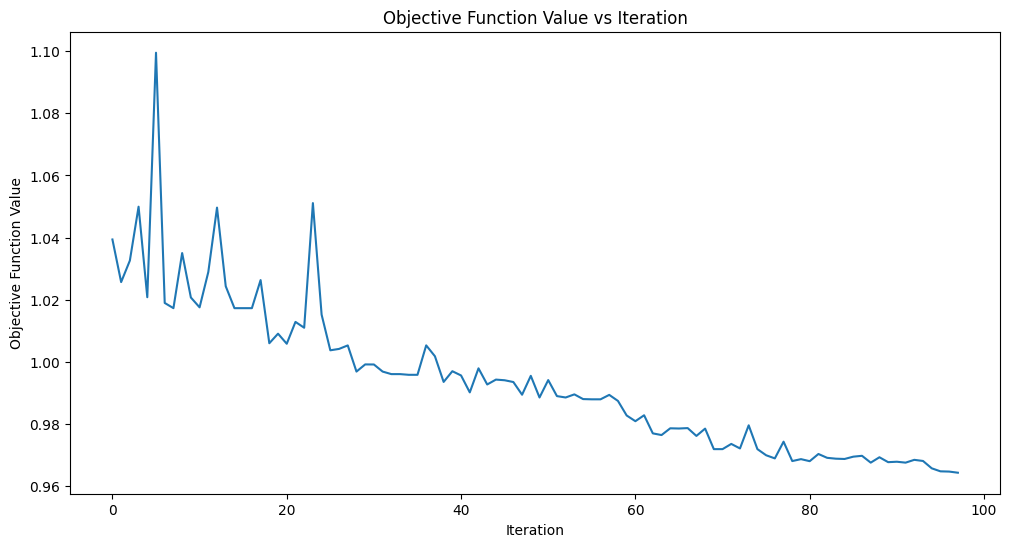

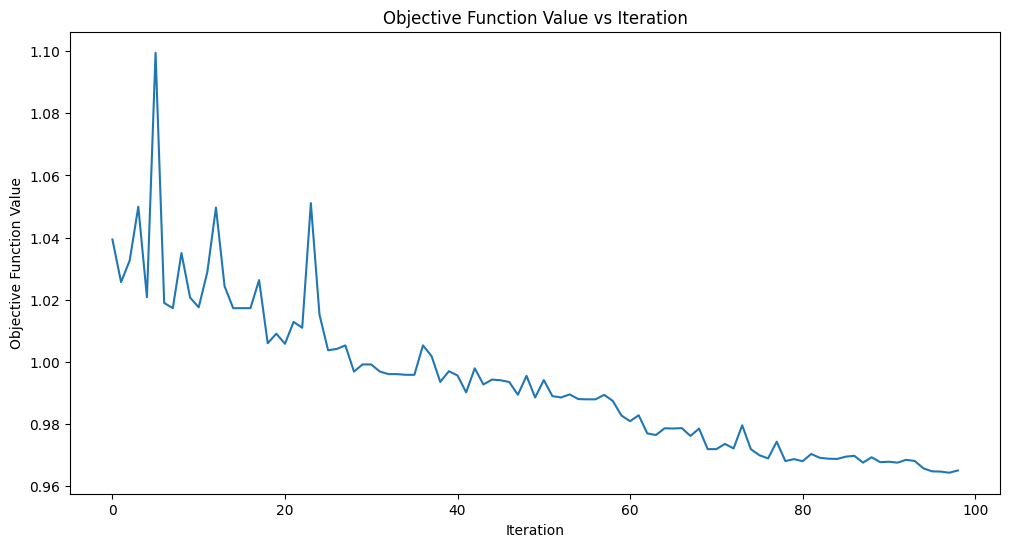

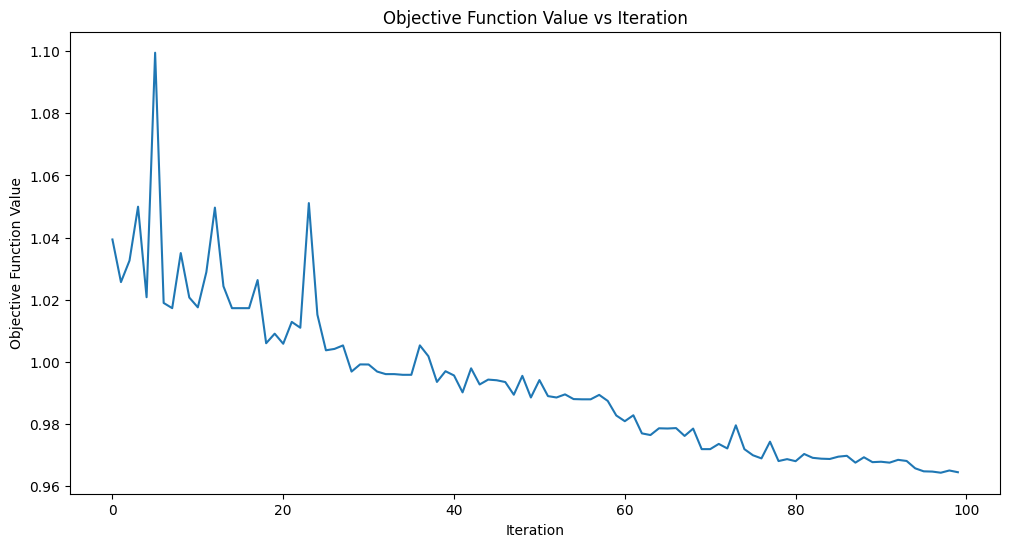

Training time: 374.69 seconds


In [25]:
import time
start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start
print(f"Training time: {round(elapsed, 2)} seconds")


In [26]:
train_score = vqc.score(X_train, y_train)
test_score = vqc.score(X_test, y_test)
print(f"Training accuracy: {train_score:.2f}")
print(f"Testing accuracy: {test_score:.2f}")



Training accuracy: 0.59
Testing accuracy: 0.51


In [33]:
def predict_review_qiskit(sample_message):
    # Preprocess the sample message
    sample_message = re.sub('[^a-zA-Z]', ' ', sample_message).lower()
    sample_message_words = sample_message.split()
    sample_message_words = [ps.stem(word) for word in sample_message_words if word not in stopwords.words('english')]
    final_message = ' '.join(sample_message_words)

    # Transform the message using the trained CountVectorizer and scale it
    temp = cv.transform([final_message]).toarray()
    temp = scaler.transform(temp)

    # Ensure the input shape matches the number of qubits
    temp = temp[:, :num_qubits]  # Trim features if they exceed num_qubits
    if temp.shape[1] < num_qubits:
        # Pad with zeros if features are fewer than num_qubits
        padding = np.zeros((1, num_qubits - temp.shape[1]))
        temp = np.hstack((temp, padding))

    # Predict and return the result
    prediction = vqc.predict(temp)
    return int(prediction)


In [34]:
result = ['Negative Review', 'Positive Review']
msg1 = "The food is really good here."
print(f"Review: '{msg1}' - {result[predict_review_qiskit(msg1)]}")

msg2 = "Food was pretty bad and the service was very slow."
print(f"Review: '{msg2}' - {result[predict_review_qiskit(msg2)]}")

msg3 = "The food was absolutely wonderful, from preparation to presentation, very pleasing."
print(f"Review: '{msg3}' - {result[predict_review_qiskit(msg3)]}")

Review: 'The food is really good here.' - Negative Review
Review: 'Food was pretty bad and the service was very slow.' - Negative Review
Review: 'The food was absolutely wonderful, from preparation to presentation, very pleasing.' - Negative Review
